```
This notebook sets up and runs a case consisting of two opposing 
instable jets, and is inspired by the Galewsky 2004 test case.

Copyright (C) 2018, 2019  SINTEF Digital

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

#Import packages we need
import numpy as np
import scipy as scipy
from scipy import integrate
from matplotlib import animation, rc
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

import os
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import datetime
import sys

from importlib import reload

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

#Set large figure sizes
#rc('figure', figsize=(16.0, 12.0))
#rc('animation', html='html5')
plt.rcParams["animation.html"] = "jshtml"

#Import our simulator
from SWESimulators import FBL, CTCS, KP07, CDKLM16, PlotHelper, Common, IPythonMagic
#Import initial condition and bathymetry generating functions:
from SWESimulators.BathymetryAndICs import *

from SWESimulators import GPUDrifterCollection, shallowWaterGPUhelpers

In [2]:
#%setup_logging --out galewsky.log
%cuda_context_handler gpu_ctx

In [24]:
#Create output directory for images
imgdir='videos_' + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
os.makedirs(imgdir)
print("Saving videos to " + imgdir)

Saving videos to videos_2019_02_15-09_47_53


# Double Galewsky Experiment for use as a data assimilation case

This notebook sets up double geostrophically balanced jet, inspired by the Galewsky test case
```
Joseph Galewsky, Richard K. Scott & Lorenzo M. Polvani (2004) An initial-
value problem for testing numerical models of the global shallow-water equations, Tellus A:
Dynamic Meteorology and Oceanography, 56:5, 429-440, DOI: 10.3402/tellusa.v56i5.14436
```
which can be found here: https://doi.org/10.3402/tellusa.v56i5.14436

It describes a test case for spheric global shallow water models representing atmospheric flow, based on a steady-state solution of a geostrophically balanced jet. A small perturbation is added to the jet, which generates long term instabilities.


## To dos in this notebook

This notebook aims to do several things:
- Use parameters applicable to the ocean, instead of the original parameters describing atmospheric flow.
- Generate a double jet steady state. Requires constant Coriolis parameter $f$ and double periodic boundary conditions.
- Investigate sensitivity of the solution based on different perturbations.

## Investigating the initial conditions based on spheric coordinates



/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.910750e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.055544e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.617785e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.246637e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.574568e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/

max u0:  2.9975302536129425
[ 0.00000000e+00  1.02739889e-03  2.07288142e-03  4.02604605e-03
  7.53626764e-03  1.36105561e-02  2.37395534e-02  4.00267087e-02
  6.52952533e-02  1.03136709e-01  1.57856934e-01  2.34275139e-01
  3.37341768e-01  4.71564957e-01  6.40271891e-01  8.44776122e-01
  1.08356618e+00  1.35166313e+00  1.64030338e+00  1.93707967e+00
  2.22661515e+00  2.49176046e+00  2.71520463e+00  2.88130057e+00
  2.97784400e+00  2.99753025e+00  2.93885145e+00  2.80628388e+00
  2.60973389e+00  2.36333566e+00  2.08380006e+00  1.78857761e+00
  1.49411062e+00  1.21440947e+00  9.60109664e-01  7.38068858e-01
  5.51468716e-01  4.00313628e-01  2.82177302e-01  1.93041656e-01
  1.28094271e-01  8.23904573e-02  5.13318253e-02  3.09547351e-02
  1.80525529e-02  1.01726215e-02  5.53338337e-03  2.90242227e-03
  1.46641246e-03  7.12778005e-04 -7.12778005e-04 -1.46641246e-03
 -2.90242227e-03 -5.53338337e-03 -1.01726215e-02 -1.80525529e-02
 -3.09547351e-02 -5.13318253e-02 -8.23904573e-02 -1.28094271e-

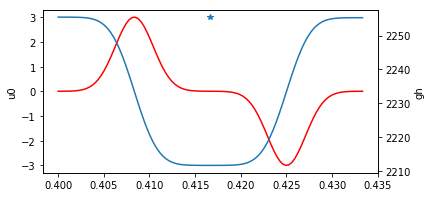

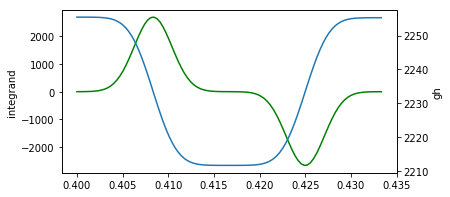

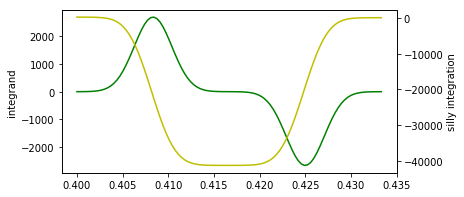

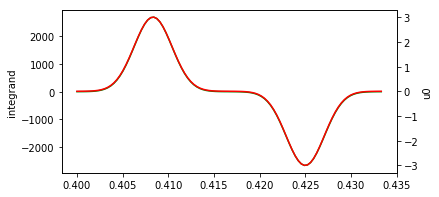

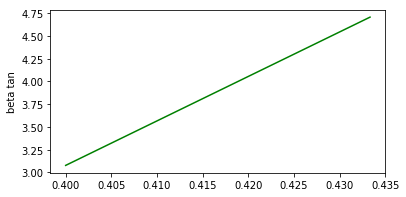

In [4]:
# global constants
OMEGA = 7.292e-5 # 1/s  - Angular rotation speed of the earth
GRAVITY = 9.80616 # m/s^2 - gravitational acceleration
RADIUS = 6.37122e6 # m - radius of the Earth
 
# parameters
#u_max = 80 #m/s
u_max = 3 #m/s   - Gulf stream has "maximum speed typically about 2.5 m/s"
phi_0 =  72*np.pi/180.0
phi_05 = 75*np.pi/180.0
phi_1 =  78*np.pi/180.0

midpoint_phi_pos = 73.5*np.pi/180
midpoint_phi_neg = 76.5*np.pi/180

phi_delta = 5.5*np.pi/180

#phi_0 =  50*np.pi/180.0
#phi_05 = 65*np.pi/180.0
#phi_1 =  80*np.pi/180.0

#midpoint_phi_pos = 58.5*np.pi/180
#midpoint_phi_neg = 72.5*np.pi/180

#phi_delta = np.sqrt(5)*5.5*np.pi/180

phi_pos_min = midpoint_phi_pos - phi_delta
phi_pos_max = midpoint_phi_pos + phi_delta
phi_neg_min = midpoint_phi_neg - phi_delta
phi_neg_max = midpoint_phi_neg + phi_delta

midpoint_phi = phi_05

e_n = np.exp( -4/(phi_delta*2)**2)
#e_n = np.exp( -4/(phi_1 - phi_05)**2)
#h_0_guestimate = 10.4e3 # m  - global mean layer depth - estimated from the plot in Galewsky Fig. 1.
h_0_guestimate = 230 # m



# Different Coriolis models
def spheric_coriolis(lat):
    return 2*OMEGA*np.sin(lat)

def const_coriolis(lat):
    return 2*OMEGA*np.sin(phi_05)*np.ones_like(lat)

def beta_coriolis(lat):
    return spheric_coriolis(phi_0) + (lat-phi_0)*(spheric_coriolis(phi_1) - spheric_coriolis(phi_0))/(phi_1 - phi_0)

# tangens corresponding to the beta model
def beta_tan(lat):
    return np.tan(phi_0) + (lat - phi_0)*(np.tan(phi_1) - np.tan(phi_0))/(phi_1 - phi_0)

# tangens corresponding to the constant coriolis model
def const_tan(lat):
    return np.tan(phi_05)

# smooth step function
def smoothstep(x,loc, slope=1):
    return np.exp(slope*x)/(np.exp(loc*slope) + np.exp(slope*x))


# The initialization function for u
def init_u_scalar(lat):
    if lat < phi_05:
        return (u_max/e_n) *np.exp(1/((lat-phi_pos_min)*(lat-phi_pos_max)))
    else:
        return -(u_max/e_n) *np.exp(1/((lat-phi_neg_min)*(lat-phi_neg_max)))


def init_u(lat):
    steps = 1 #smoothstep(lat, phi_0,  slope=50)*(1-smoothstep(lat, phi_05, slope=50)) + \
            #smoothstep(lat, phi_05, slope=50)*(1-smoothstep(lat, phi_1,  slope=50))
    #print("steps: ", steps)
    if np.isscalar(lat):
        return steps*init_u_scalar(lat)
    else:
        
        out = np.zeros_like(lat)
        for i in range(len(lat)):
            if lat[i] > phi_0 and lat[i] <= phi_1:
                out[i] = init_u_scalar(lat[i])
            if out[i] == np.inf:
                out[i] = 0.0
        return steps*out
    

# Integrand for initialization of h
def init_h_integrand(lat, coriolis_function, tan_function):
    return RADIUS*init_u(lat)*(coriolis_function(lat) + (tan_function(lat)/RADIUS)*init_u(lat))

phi = np.linspace(phi_0, phi_1, num=100)
u0 = np.zeros_like(phi)
u0 = init_u(phi)

def generate_gh0(lat, coriolis_function, tan_function, lat_0, h_0):
    gh0 = np.zeros_like(lat)

    for i in range(lat.size):
        gh0[i] = GRAVITY*h_0 - scipy.integrate.quadrature(init_h_integrand, phi_0, lat[i], 
                                                          args=(coriolis_function, tan_function))[0]

    # For some wierd reason, the integration fails for the southmost value where the expression for
    # u is used.
    # This is a dirty fix:
    #for i in range(gh0.size):
    #    if np.isnan(gh0[i]):
    #        gh0[i] = 0.5*(gh0[i+1] + gh0[i-1])
    return gh0
gh0 = generate_gh0(phi, spheric_coriolis, np.tan, phi_0, h_0_guestimate)

# Look at the integrand for h
integrand = init_h_integrand(phi, spheric_coriolis, np.tan)


silly_integration = integrand.sum()*np.ones_like(integrand)
for i in range(1,len(integrand)):
    silly_integration[i] = silly_integration[i-1] - integrand[i]

fig = plt.figure(figsize=(6,3))
plt.plot(phi/np.pi, u0, 'r')
plt.plot(phi_05/np.pi, np.max(u0), "*")
plt.ylabel("u0")
print("max u0: ", np.max(u0))

plt.twinx()
plt.plot(phi/np.pi, gh0)
plt.ylabel("gh")


fig = plt.figure(figsize=(6,3))
plt.plot(phi/np.pi, integrand, 'g')
plt.ylabel("integrand")

plt.twinx()
plt.plot(phi/np.pi, gh0)
plt.ylabel("gh")

fig = plt.figure(figsize=(6,3))
plt.plot(phi/np.pi, integrand, 'g')
plt.ylabel("integrand")

plt.twinx()
plt.plot(phi/np.pi, silly_integration, 'y')
plt.ylabel("silly integration")

fig = plt.figure(figsize=(6,3))
plt.plot(phi/np.pi, integrand, 'g')
plt.ylabel("integrand")

plt.twinx()
plt.plot(phi/np.pi, u0, 'r')
plt.ylabel("u0")

fig = plt.figure(figsize=(6,3))
plt.plot(phi/np.pi, beta_tan(phi), 'g')
plt.ylabel("beta tan")


print(u0)


### Coriolis forcing

We compare the use of proper Coriolis forcing, $\beta$-model, and constant $f$.

max((spheric, const, beta_model)): (0.0001426530460910182, 0.00014087062250599773, 0.0001426530460910182)
min((spheric, const, beta_model)): (0.0001387020823364852, 0.00014087062250599773, 0.0001387020823364852)
midpoint_phi:  1.3089969389957472 0.00014087062250599773


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.908132e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.048616e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.604604e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.244929e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.572411e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.247546e-03
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.261252e-03
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.460137e-03
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.572410e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.104957e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/

gh_mean:  2233.4103824741264
gh_beta[0], gh_beta[-1]:  2255.4168 2255.2231687914423
gh[0], gh[-1]:  2255.4168 2254.643639538626


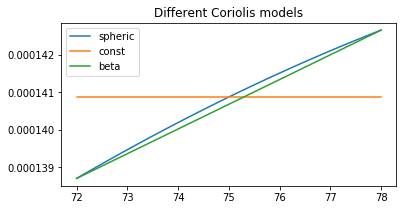

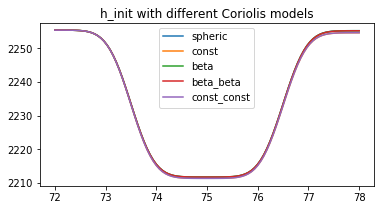

In [5]:
# The three different Coriolis models:

spheric = spheric_coriolis(phi)
const = const_coriolis(phi)
beta_model = beta_coriolis(phi)

fig = plt.figure(figsize=(6,3))
plt.plot(phi*180/np.pi, spheric, label="spheric")
plt.plot(phi*180/np.pi, const, label="const")
plt.plot(phi*180/np.pi, beta_model, label="beta")
plt.legend()
plt.title("Different Coriolis models")

print("max((spheric, const, beta_model)):", (spheric.max(), const.max(), beta_model.max()))
print("min((spheric, const, beta_model)):", (spheric.min(), const.min(), beta_model.min()))

print("midpoint_phi: ", midpoint_phi, spheric_coriolis(midpoint_phi))


#init_h_integral_beta  = lambda lat: RADIUS*init_u(lat)*(beta_coriolis(lat) + (np.tan(lat)/RADIUS)*init_u(lat))
#init_h_integral_const = lambda lat: RADIUS*init_u(lat)*(const_coriolis(lat) + (np.tan(lat)/RADIUS)*init_u(lat))
gh0_beta  = generate_gh0(phi, beta_coriolis, np.tan, phi_0, h_0_guestimate)
gh0_const = generate_gh0(phi, const_coriolis, np.tan, phi_0, h_0_guestimate)
gh0_beta_beta = generate_gh0(phi, beta_coriolis, beta_tan, phi_0, h_0_guestimate)
gh0_const_const = generate_gh0(phi, const_coriolis, const_tan, phi_0, h_0_guestimate)

fig = plt.figure(figsize=(6,3))
plt.plot(phi*180/np.pi, gh0, label="spheric")
plt.plot(phi*180/np.pi, gh0_const, label="const")
plt.plot(phi*180/np.pi, gh0_beta, label="beta")
plt.plot(phi*180/np.pi, gh0_beta_beta, label="beta_beta")
plt.plot(phi*180/np.pi, gh0_const_const, label="const_const")

plt.legend()
plt.title("h_init with different Coriolis models")

gh_mean = np.mean(gh0_const_const)
print("gh_mean: ", gh_mean)
print("gh_beta[0], gh_beta[-1]: ", gh0_beta_beta[0], gh0_beta_beta[-1])
print("gh[0], gh[-1]: ", gh0_const_const[0], gh0_const_const[-1])



## Finding the parameter $h_0$

It is defined such that the global mean of $h$ is 1000

In [6]:
#h_mean = 10000 # m
h_mean = 230 # m

# integrand above phi_1:
double_int_above_phi_1 = scipy.integrate.quadrature(init_h_integrand, phi_0, phi_1, 
                                                    args=(beta_coriolis, beta_tan))[0]


def mean_integrand(lat, coriolis_function):
    return np.cos(lat)*scipy.integrate.quadrature(init_h_integrand, phi_0, lat, 
                                                  args=(coriolis_function, beta_tan))[0]


def mean_dbl_integrand(lat, y):
    return np.cos(y)*RADIUS*init_u(lat)*(beta_coriolis(lat) + (beta_tan(lat)/RADIUS)*init_u(lat))

def mean_dbl_integrand_above_phi_1(lat, y):
    return np.cos(y)*double_int_above_phi_1



print("double_int_above_phi_1: ", double_int_above_phi_1)
print("double_int_above_phi_1:  10658.96186949533 (with spherical)")


h_0_analytic = h_mean + (1.0/(2*GRAVITY))*double_int_above_phi_1*(1.0 - np.sin(phi_1) ) + \
               (1.0/(2*GRAVITY))*scipy.integrate.dblquad(mean_dbl_integrand, 
                                                         phi_0, phi_1, # np.pi/2.0,
                                                         lambda x: phi_0*np.ones_like(x), 
                                                         lambda x: x)[0]





print("h_0_guestimate: ", h_0_guestimate)
print("original h_0_analytic: 10152.969251376311")
print("h_0_analytic: ", h_0_analytic)

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.458367e-03
  AccuracyWarning)


double_int_above_phi_1:  0.1936312085574765
double_int_above_phi_1:  10658.96186949533 (with spherical)
h_0_guestimate:  230
original h_0_analytic: 10152.969251376311
h_0_analytic:  230.03044236078358


## Investigating initial conditions with Cartesian coordinates

In [7]:
distance_between_latitudes = 111e3 # m
distance_equator_north_pole = 10e6

y_0   = distance_between_latitudes*phi_0*180/np.pi
y_1   = distance_between_latitudes*phi_1*180/np.pi
y_mid = distance_between_latitudes*midpoint_phi*180/np.pi

degrees_0   = phi_0*180/np.pi
degrees_1   = phi_1*180/np.pi
degrees_mid = midpoint_phi*180/np.pi

print ("phi_0, phi_1, phi_mid: ", (phi_0, phi_1, midpoint_phi))
print ("degrees_0, degrees_1, degrees_mid: ", (degrees_0, degrees_1, degrees_mid))
print ("y_0, y_1, y_mid: ", (y_0, y_1, y_mid))
print ("y_0_rel, y_1_rel, y_mid_rel: ", 
       (y_0/distance_equator_north_pole, y_1/distance_equator_north_pole, y_mid/distance_equator_north_pole))


phi_0, phi_1, phi_mid:  (1.2566370614359172, 1.361356816555577, 1.3089969389957472)
degrees_0, degrees_1, degrees_mid:  (72.0, 78.0, 75.00000000000001)
y_0, y_1, y_mid:  (7992000.0, 8657999.999999998, 8325000.0)
y_0_rel, y_1_rel, y_mid_rel:  (0.7992, 0.8657999999999998, 0.8325)


In [28]:
# We set the boundary in north and south to be at 3*90/8 degrees and 5*90/8 north
y_south = degrees_0*distance_between_latitudes
y_north = degrees_1*distance_between_latitudes

ny = 300
dy = (y_north - y_south)/ny
dy_01 = (y_1-y_0)/ny
dx = dy
print("(dx, dy): ", (dx, dy))

# Choose the domain to be as long as the Galewsky case we created earlier
nx = 500


# Choose the domain to go around the earth (in x-direction)
distance_between_longitudes_45 = 78e3 # m
distance_between_longitudes_75 = 28.7e3 # m
#earth_circumsize_at_midpoint_phi = distance_between_longitudes_45*360
#nx = np.floor(earth_circumsize_at_midpoint_phi/dx)
print("(nx, ny): ", (nx, ny))
print("(y_south, y_north)", (y_south, y_north))
print("(y_0, y_1)", (y_0, round(y_1)))
print("(dy, dy_01)", (dy, dy_01))

(dx, dy):  (2220.0, 2220.0)
(nx, ny):  (500, 300)
(y_south, y_north) (7992000.0, 8658000.0)
(y_0, y_1) (7992000.0, 8658000)
(dy, dy_01) (2220.0, 2219.9999999999936)


In [9]:
# Timestep
max_dt = 0.25*dx/(np.max(u0 + np.sqrt(gh0)))
dt = 0.8*max_dt
print("max_dt: ", max_dt)
print("dt: ", dt)
print("max dt gravity:  ", 0.25*dx/(np.max(np.sqrt(gh0))))
print("max dt momentum: ", 0.25*dx/(np.max(u0)))

max_dt:  11.042260927686467
dt:  8.833808742149174
max dt gravity:   11.686368527726028
max dt momentum:  185.15242651214444


beta:  5.932378009809337e-12
y_zero_reference_cell:  0.0


Text(0.5, 1.0, 'Different Coriolis $\\beta$-models')

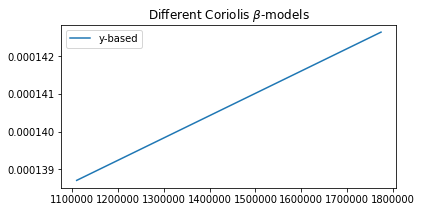

In [10]:
# Our beta model compared to the beta model defined in phi

def our_beta_model(f, beta, cell_id, y_zero_reference_cell, dy):
    return f + beta * (cell_id - y_zero_reference_cell - 0.0)*dy


cells = np.linspace(0,ny-1, ny)
y_zero_reference_cell = (y_0 - y_south)/dy
f0 = spheric_coriolis(phi_0)
beta = (spheric_coriolis(phi_1)-spheric_coriolis(phi_0))/ (y_1 - y_0)  #df/dy
print("beta: ", beta)
print("y_zero_reference_cell: ", y_zero_reference_cell)

fig = plt.figure(figsize=(6,3))
#plt.plot(distance_between_latitudes*phi*180/np.pi, beta_model, label="lat-based")
plt.plot(distance_between_latitudes*10 + cells*dy,
         our_beta_model(f0, beta, cells, y_zero_reference_cell, dy),
         label='y-based')
plt.legend()
plt.title(r'Different Coriolis $\beta$-models')



## Resulting steady-state initial conditions

In order to obtain the steady-state initial conditions for 2D Cartesian grids, we

1. Calculate $u_{temp}$ based on the expression for initial $u$ from the paper
2. Calculate initial $h_{init}$ using the expression for $u_{temp}$.
3. Re-calculate initial $u_{init}$ by using the expression for geostrophic balance on the initial $h_{init}$.
4. Obtain $hu_{init} = h_{init} u_{init}$.

sim_phi.shape:  (304,)
sim_u_init.shape:  (304,)


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.908010e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.272188e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.034849e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.043914e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.117307e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.910630e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 3.276720e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.042025e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 5.050647e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 7.127302e-05
  AccuracyWarning)
/home/havahol/miniconda3/envs/

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 8.990453e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 9.455754e-04
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.285753e-03
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.234325e-03
  AccuracyWarning)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/integrate/quadrature.py:201: AccuracyWarning: maxiter (50) exceeded. Latest difference = 1.209523e-03
  AccuracyWarning)
/home/havahol/miniconda3/envs/

sim_h_init_mean:  227.80056487932606
redef_hu_init[0], redef_hu_init[-1]:  0.0 0.0


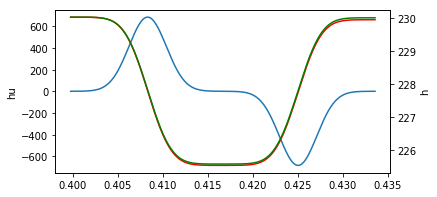

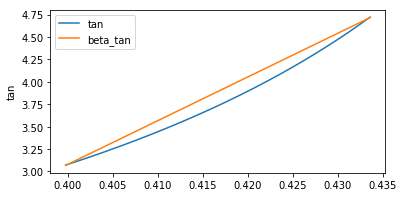

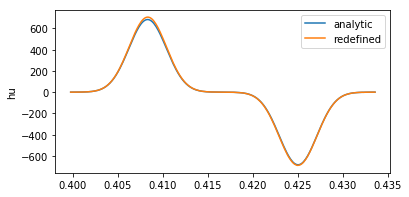

In [11]:
# Define u and H with the above grid resulution 
# These are defined based on phi (with two ghost cells)
# and can be directly put into an array represented by y

phi_south = phi_0 
phi_north = phi_1 
dy_phi = (phi_north - phi_south)/ny
sim_phi = np.linspace(phi_south - 2*dy_phi, phi_north + 2*dy_phi, ny+4)
print("sim_phi.shape: ", sim_phi.shape)

sim_u_init = init_u(sim_phi)
print("sim_u_init.shape: ", sim_u_init.shape)                         

sim_gh_init_beta = generate_gh0(sim_phi, beta_coriolis, beta_tan, phi_south, h_0_analytic)
sim_h_init_beta = sim_gh_init_beta/GRAVITY

sim_gh_init = generate_gh0(sim_phi, const_coriolis, const_tan, phi_south, h_0_analytic)
sim_h_init = sim_gh_init/GRAVITY

sim_h_init_mean = np.mean(sim_h_init)
print("sim_h_init_mean: ", sim_h_init_mean)

sim_hu_init = sim_u_init*sim_h_init


# Calculate hu which is in geotrophic balance wrt sim_h_init (it's slope is equal to the slope of eta)
redef_hu_init = np.zeros_like(sim_h_init)
for j in range(1, len(redef_hu_init)-1):
    redef_hu_init[j] = - (GRAVITY*sim_h_init_mean/f0)*(sim_h_init[j+1]-sim_h_init[j-1])/(2*dy)
    #y0_offset = 32.5
    #y0_offset = 10.5 # Compensating for the open boundary, and location of cell centeres.
    #redef_hu_init[j] = - (GRAVITY*sim_h_init_mean/our_beta_model(f0, beta, j, y_zero_reference_cell+y0_offset, dy))*\
    #                (sim_h_init[j+1]-sim_h_init[j-1])/(2*dy)


fig = plt.figure(figsize=(6,3))
plt.plot(sim_phi/np.pi, sim_hu_init)
plt.ylabel("hu")

plt.twinx()
plt.plot(sim_phi/np.pi, sim_h_init, color='r')
plt.plot(sim_phi/np.pi, sim_h_init_beta, color='g')
plt.ylabel("h")


fig = plt.figure(figsize=(6,3))
plt.plot(sim_phi/np.pi, np.tan(sim_phi), label='tan')
plt.plot(sim_phi/np.pi, beta_tan(sim_phi), label='beta_tan')
beta_tan
plt.ylabel("tan")
plt.legend()


fig = plt.figure(figsize=(6,3))
plt.plot(sim_phi/np.pi, sim_hu_init, label='analytic')
plt.plot(sim_phi/np.pi, redef_hu_init, label='redefined')
plt.ylabel("hu")
plt.legend()

print("redef_hu_init[0], redef_hu_init[-1]: ", redef_hu_init[0], redef_hu_init[-1])


if False:
    h_syM_check = sim_h_init + sim_h_init[-1::-1]
    fig = plt.figure(figsize=(6,3))
    plt.plot(sim_phi/np.pi, h_syM_check, label='h sym check')
    plt.legend()

    u_syM_check = sim_hu_init - sim_hu_init[-1::-1]
    fig = plt.figure(figsize=(6,3))
    plt.plot(sim_phi/np.pi, u_syM_check, label='u_syM_check')
    plt.legend()

    redef_u_syM_check = redef_hu_init - redef_hu_init[-1::-1]
    fig = plt.figure(figsize=(6,3))
    plt.plot(sim_phi/np.pi, redef_u_syM_check, label='redef_u_syM_check')
    plt.legend()
    

# Perturbation function

delta_eta:  4.493406789678403
phi_delta:  0.09599310885968812
mid_cell_x_pos, mid_cell_x_neg 28 226
phi_delta:   0.09599310885968812
pert_alpha:  0.09599310885968812
pert_beta:   0.019198621771937624


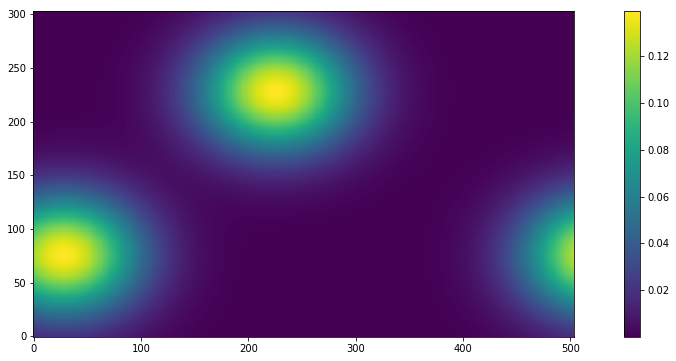

In [16]:
ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (int(ny)+ ghosts[0]+ghosts[2], int(nx)+ ghosts[1]+ghosts[3])
eta_pert = np.zeros(dataShape)
eta_pert_rand = np.zeros(dataShape)
delta_eta = np.max(sim_h_init) - np.min(sim_h_init)
print("delta_eta: ", delta_eta)
print("phi_delta: ", phi_delta)

def perturb_eta(eta_pert, ghosts):
    mid_cell_x_pos = int(nx/5) + ghosts[3]
    mid_cell_x_neg = int(nx/5) + ghosts[3]
    
    return add_perturbation(eta_pert, ghosts, mid_cell_x_pos, mid_cell_x_neg)

def random_perturb_eta(eta_pert, ghosts):
    mid_cell_x_pos = int(np.random.rand()*eta_pert.shape[1] + ghosts[3])
    mid_cell_x_neg = int(np.random.rand()*eta_pert.shape[1] + ghosts[3])
    print("mid_cell_x_pos, mid_cell_x_neg", mid_cell_x_pos, mid_cell_x_neg)
    return add_perturbation(eta_pert, ghosts, mid_cell_x_pos, mid_cell_x_neg)
    
def add_perturbation(eta_pert, ghosts, mid_cell_x_pos, mid_cell_x_neg):
    nx = eta_pert.shape[1] - ghosts[1] - ghosts[3]
    ny = eta_pert.shape[0] - ghosts[0] - ghosts[2]
    
    radius_y_cells = distance_between_longitudes_75*180/dx
    
    mid_cell_y_pos = int(1*eta_pert.shape[0]/4)
    mid_cell_y_neg = int(3*eta_pert.shape[0]/4)
    #mid_cell_x_pos = int(nx/5) + ghosts[3]
    #mid_cell_x_neg = int(nx/5) + ghosts[3]
    pert_alpha = phi_delta #1/6 # 1/3
    pert_beta = phi_delta/5 # 1/30 # 1/15
    h_hat = 0.12*delta_eta

    print("phi_delta:  ", phi_delta)
    print("pert_alpha: ", pert_alpha)
    print("pert_beta:  ", pert_beta)
    
    
    for j in range(ny+ghosts[2]+ghosts[0]):
        for i in range(nx+ghosts[3]+ghosts[1]):
            
            cell_diff_x_pos = i-mid_cell_x_pos
            cell_diff_x_pos = min(abs(cell_diff_x_pos), abs(cell_diff_x_pos+nx), abs(cell_diff_x_pos-nx))
            cell_diff_x_neg = i-mid_cell_x_neg
            cell_diff_x_neg = min(abs(cell_diff_x_neg), abs(cell_diff_x_neg+nx), abs(cell_diff_x_neg-nx))
            
            
            squared_dist_y_pos = ((1/pert_beta)*(np.pi/180)*(j-mid_cell_y_pos)*dy/distance_between_latitudes)**2
            squared_dist_y_neg = ((1/pert_beta)*(np.pi/180)*(j-mid_cell_y_neg)*dy/distance_between_latitudes)**2
            squared_dist_x_pos = ((1/pert_alpha)*(np.pi/180)*(cell_diff_x_pos)*dx/(distance_between_longitudes_75))**2
            squared_dist_x_neg = ((1/pert_alpha)*(np.pi/180)*(cell_diff_x_neg)*dx/(distance_between_longitudes_75))**2
            
            lat = np.cos(75*np.pi/180) # approximation into the beta-plane
            

            eta_pert[j,i] += h_hat*lat*np.exp(-squared_dist_y_pos - squared_dist_x_pos) +\
                             h_hat*lat*np.exp(-squared_dist_y_neg - squared_dist_x_neg)
   

            
#perturb_eta(eta_pert, ghosts)
#fig = plt.figure(figsize=(18,6))
#plt.imshow(eta_pert, origin='lower', interpolation='none')
#plt.colorbar()

random_perturb_eta(eta_pert_rand, ghosts)
fig = plt.figure(figsize=(18,6))
plt.imshow(eta_pert_rand, origin='lower', interpolation='none')
plt.colorbar()



# Set up and animate simulations

In [17]:

# Set initial conditions common to all simulators
sim_args = {
"gpu_ctx": gpu_ctx,
"nx": int(nx), "ny": int(ny),
"dx": dy, "dy": dy,
"dt": dt,
"g": GRAVITY,
"f": f0,
#"coriolis_beta": beta,
"coriolis_beta": 0.0,
"r": 0.0,
"y_zero_reference_cell": y_zero_reference_cell
}

eta_max = 1.5
hu_max = 1.5

## Animation function

In [18]:
def sim_animation(simulator, T, plot_dt, crossection=False, spinUp=False, snapshot=False):
    
    #Helper function which simulates and plots the solution
    if spinUp:
        t = sim.step(20*plot_dt*dt)
    
    eta1, hu1, hv1 = sim.download(interior_domain_only=True)
    print("sim.download in sim_animator - eta1.shape: ", eta1.shape)
    
    dx_km = sim.dx/1000
    dy_km = sim.dy/1000
    
    #Create figure and plot initial conditions
    fig = plt.figure(figsize=(12, 12), constrained_layout=True)
    domain_extent = [0, eta1.shape[1]*dx_km, 0, eta1.shape[0]*dy_km]
    y_axis_eta = np.linspace(0.5*dy_km, (sim.ny+0.5)*dy_km, eta1.shape[0])
    y_axis_hu  = np.linspace(0.5*dy_km, (sim.ny+0.5)*dy_km, hu1.shape[0])
    y_axis_hv  = np.linspace(0.5*dy_km, (sim.ny+0.5)*dy_km, hv1.shape[0])
    mid_cell_x = int(eta1.shape[1]/2)
    pert_cell_x = int(eta1.shape[1]/5)
    
    gs = fig.add_gridspec(4,5)
    
    ax_eta = fig.add_subplot(gs[0,0:-2])
    sp_eta = ax_eta.imshow(eta1, interpolation="spline36", origin='bottom', vmin=-eta_max, vmax=eta_max, extent=domain_extent)
    solid_eta  = ax_eta.plot([mid_cell_x*dx_km, mid_cell_x*dx_km],   [0, eta1.shape[0]*dy_km], 'C9-')
    dotted_eta = ax_eta.plot([pert_cell_x*dx_km, pert_cell_x*dx_km], [0, eta1.shape[0]*dy_km], 'C3-.')
    ax_eta.set_title('$\eta$')
    
    drifters = ax_eta.scatter(x=None, y=None, color='C6')
    if sim.hasDrifters:
        drifters.set_offsets(sim.drifters.getDrifterPositions()/1000)
    
    ax_u = fig.add_subplot(gs[1,0:-2])
    sp_u = ax_u.imshow(hu1, interpolation="spline36", origin='bottom', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    solid_u  = ax_u.plot([mid_cell_x*dx_km, mid_cell_x*dx_km],   [0, eta1.shape[0]*dy_km], 'C9-')
    dotted_u = ax_u.plot([pert_cell_x*dx_km, pert_cell_x*dx_km], [0, eta1.shape[0]*dy_km], 'C3-.')
    ax_u.set_title('$hu$')
   
    ax_v = fig.add_subplot(gs[2,0:-2])
    sp_v = ax_v.imshow(hv1, interpolation="spline36", origin='bottom', vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    solid_v  = ax_v.plot([mid_cell_x*dx_km, mid_cell_x*dx_km],   [0, eta1.shape[0]*dy_km], 'C9-')
    dotted_v = ax_v.plot([pert_cell_x*dx_km, pert_cell_x*dx_km], [0, eta1.shape[0]*dy_km], 'C3-.')
    ax_v.set_title('$hv$')
   
    if crossection:
        ax_eta_cs = fig.add_subplot(gs[0,-2:])
        cs_eta_init, = ax_eta_cs.plot(y_axis_eta, eta1[:, mid_cell_x], 'C1--')
        cs_eta,      = ax_eta_cs.plot(y_axis_eta, eta1[:, mid_cell_x], 'C9-' )
        cs_eta_pert, = ax_eta_cs.plot(y_axis_eta, eta1[:, pert_cell_x], 'C3-.')
        ax_eta_cs.set_ylim(-eta_max*1.3, eta_max*1.3)
        ax_eta_cs.grid()
        
        ax_hu_cs = fig.add_subplot(gs[1,-2:])
        cs_hu_init, = ax_hu_cs.plot(y_axis_hu, hu1[:, mid_cell_x], 'C1--')
        cs_hu,      = ax_hu_cs.plot(y_axis_hu, hu1[:, mid_cell_x], 'C9-' )
        cs_hu_pert, = ax_hu_cs.plot(y_axis_hu, hu1[:, pert_cell_x], 'C3-.')
        ax_hu_cs.set_ylim(-hu_max, hu_max)
        ax_hu_cs.grid()
        
        ax_hv_cs = fig.add_subplot(gs[2,-2:])
        cs_hv_init, = ax_hv_cs.plot(y_axis_hv, hv1[:, mid_cell_x], 'C1--')
        cs_hv,      = ax_hv_cs.plot(y_axis_hv, hv1[:, mid_cell_x], 'C9-' )
        cs_hv_pert, = ax_hv_cs.plot(y_axis_hv, hv1[:, pert_cell_x], 'C3-.')
        ax_hv_cs.set_ylim(-hu_max, hu_max)
        ax_hv_cs.grid()
    
    ax_vort = fig.add_subplot(gs[3,0:-2])
    gen_vort = shallowWaterGPUhelpers.genColors(eta1, hu1/h_mean, hv1/h_mean, 
                                                        cmap=plt.cm.viridis, vmax=3, vmin=-3)
    sp_vort = ax_vort.imshow(gen_vort, interpolation="spline36", origin='bottom', 
                            vmin=-hu_max, vmax=hu_max, extent=domain_extent)
    ax_vort.set_title('Vorticity')
    
    
    fig.suptitle("Time = {:04.0f} s ({:s})".format(sim.t, sim.__class__.__name__), fontsize=18)
        
    if snapshot:
        return fig
    
    def animate(i):
        if (i>0):
            t = sim.step(plot_dt*dt)
        else:
            t = sim.t
        eta1, hu1, hv1 = sim.download(interior_domain_only=True)
        
        #Update plots
        fig.sca(ax_eta)
        sp_eta.set_data(eta1)
        
        if sim.hasDrifters:
            drifters.set_offsets(sim.drifters.getDrifterPositions()/1000)
        
        fig.sca(ax_u)
        sp_u.set_data(hu1)
        
        fig.sca(ax_v)
        sp_v.set_data(hv1)
        
        fig.sca(ax_vort)
        gen_vort = shallowWaterGPUhelpers.genColors(eta1, hu1/h_mean, hv1/h_mean, 
                                                            cmap=plt.cm.viridis, vmax=3, vmin=-3)
        sp_vort.set_data(gen_vort)
        
        if crossection:
            cs_eta.set_data(y_axis_eta, eta1[:, mid_cell_x])
            cs_hu.set_data(y_axis_hu,    hu1[:, mid_cell_x])
            cs_hv.set_data(y_axis_hv,    hv1[:, mid_cell_x])
            cs_eta_pert.set_data(y_axis_eta, eta1[:, pert_cell_x])
            cs_hu_pert.set_data(y_axis_hu,    hu1[:, pert_cell_x])
            cs_hv_pert.set_data(y_axis_hv,    hv1[:, pert_cell_x])
        
        fig.suptitle("Time = {:04.0f} s ({:s})".format(t, sim.__class__.__name__), fontsize=18)
        print("."+str(i)+".", end='')

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(T), interval=100)
    plt.close(fig)
    return anim

# Steady-state solution for CDKLM

Steady state is maintained for a long simulation time

sim_h_init.shape:  (404,)
eta0.shape (404, 726)
(ny, nx):  (400, 722)
max eta and hu:  (2.2385467529296874, 857.4649658203125)
sim_h_init_mean:  228.18862493142228
sim_args['y_zero_reference_cell']:  0.0
sim.download in sim_animator - eta1.shape:  (400, 722)
sim.download in sim_animator - eta1.shape:  (400, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (400, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.d

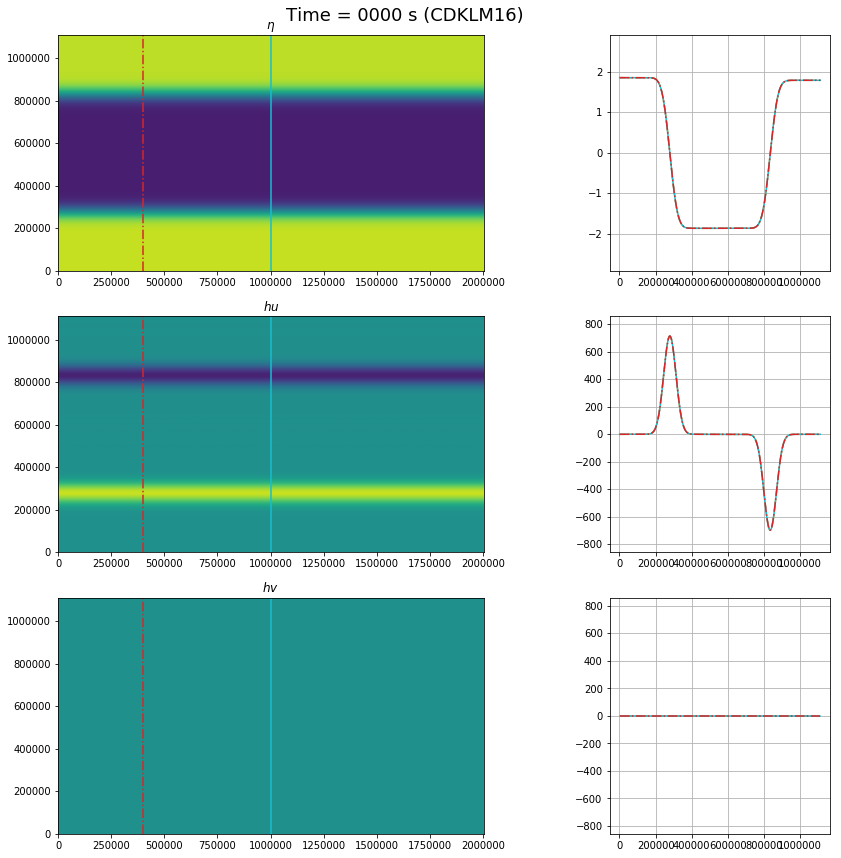

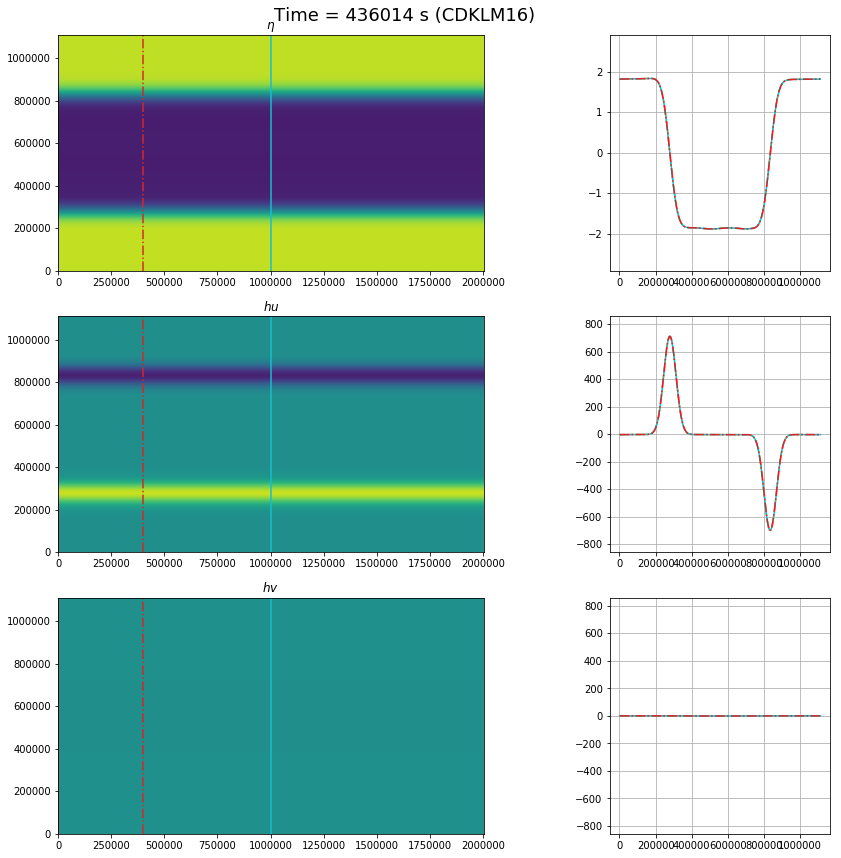

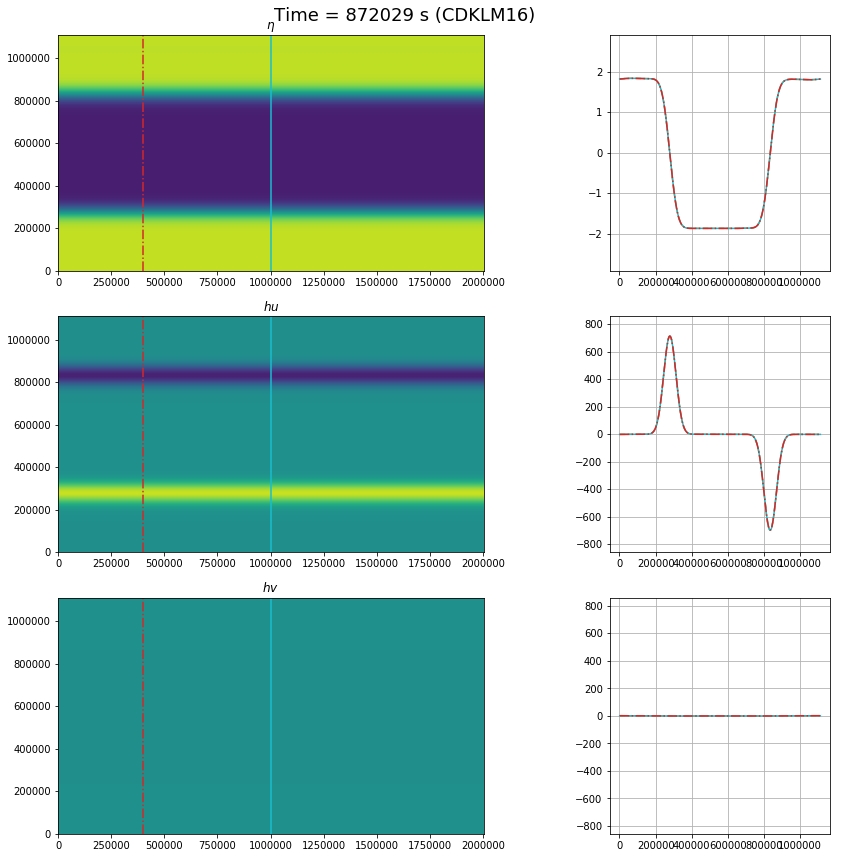

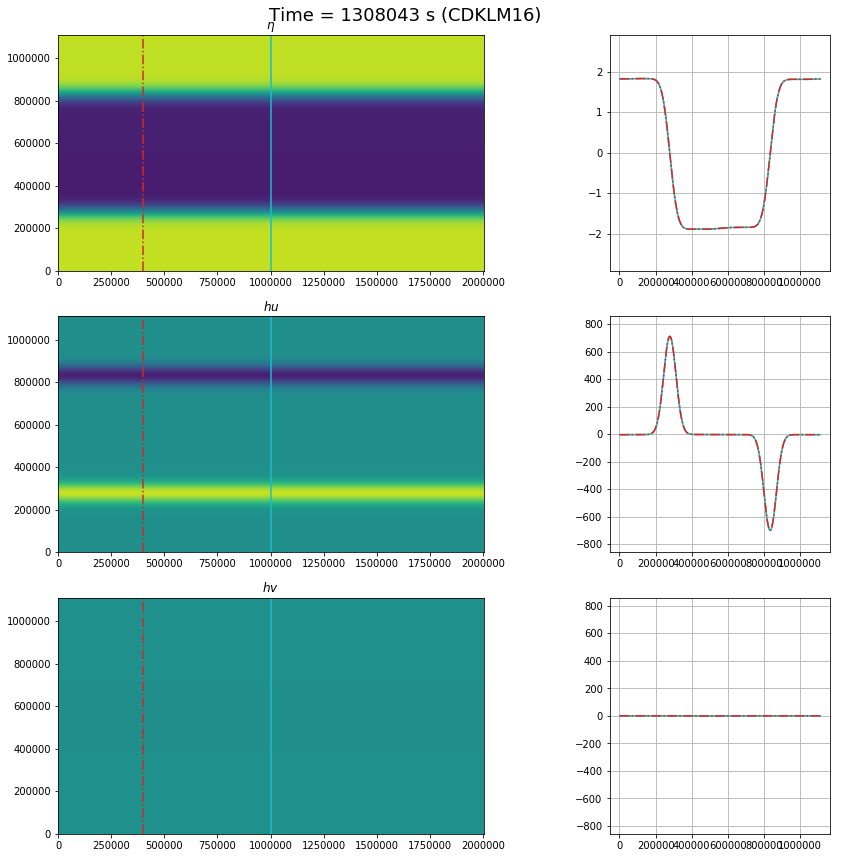

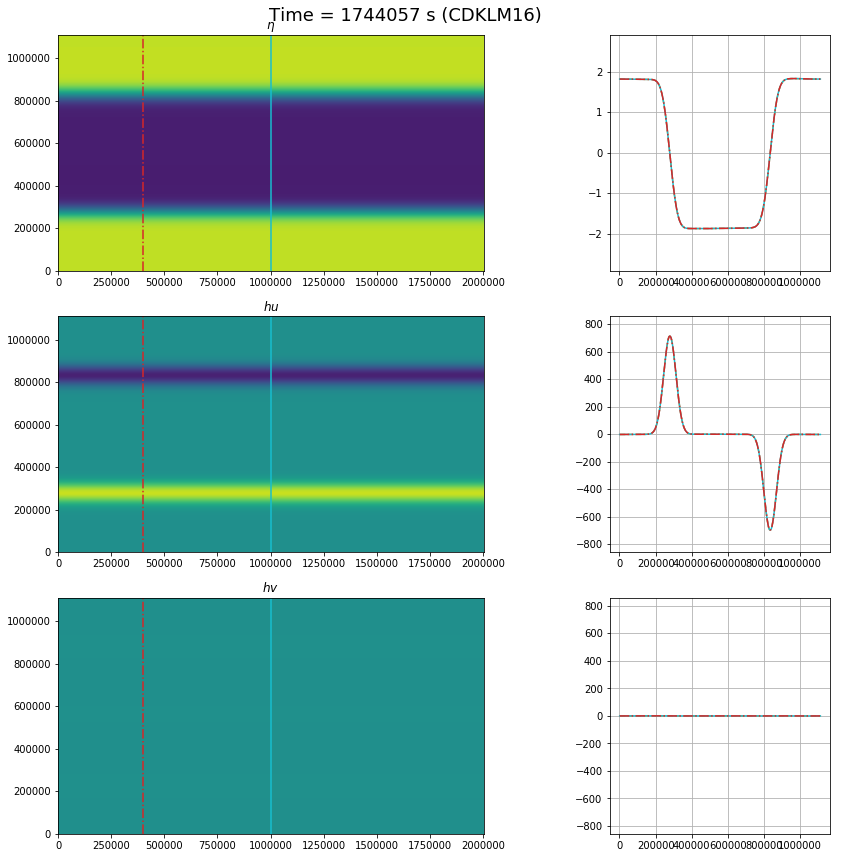

In [40]:
if 'sim' in globals():
    sim.cleanUp()
reload(CDKLM16)
    
ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    hu0[:,i] = redef_hu_init

eta_max = np.max(np.abs(eta0))*1.2
hu_max = np.max(np.abs(hu0))*1.2
print("max eta and hu: ", (eta_max, hu_max))
print("sim_h_init_mean: ", sim_h_init_mean)


#Create perturbation
#perturb_eta(eta0, ghosts)

#Initialize simulator
cdklm_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0, "rk_order": 2,
              "boundary_conditions": Common.BoundaryConditions(2,2,2,2)}
print("sim_args['y_zero_reference_cell']: ", sim_args['y_zero_reference_cell'])
sim = CDKLM16.CDKLM16(**cdklm_args, **sim_args)

#Run a simulation and plot it
#sim_animation(sim, T=20, plot_dt=100,  crossection=True)
#anim = sim_animation(sim, T=70, plot_dt=500, crossection=True, spinUp=False)
#anim = sim_animation(sim, T=70, plot_dt=500, crossection=True, spinUp=False)

save_anim = True

# init
cdklm_galewsky_steady_anim = sim_animation(sim, T=80, plot_dt=500, crossection=True, spinUp=False)
#cdklm_galewsky_steady_anim = sim_animation(sim, T=30, plot_dt=500, crossection=True, spinUp=True)
if save_anim:
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

    # run, animate and save
    cdklm_galewsky_steady_anim.save(imgdir+'/steady_double_galewsky_cdklm_1.mp4')
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

    # run, animate and save
    cdklm_galewsky_steady_anim.save(imgdir+'/steady_double_galewsky_cdklm_2.mp4')
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

    # run, animate and save
    cdklm_galewsky_steady_anim.save(imgdir+'/steady_double_galewsky_cdklm_3.mp4')
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

    # run, animate and save
    cdklm_galewsky_steady_anim.save(imgdir+'/steady_ocean_galewsky_cdklm_4.mp4')
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
    print("Done")

#cdklm_galewsky_steady_anim
    


# Gravitational wave - CDKLM

We see the gravitational wave leave the domain, and the state becomes (appearantly) steady. Instabilities starts to be visible after twice the simulation $t = $ 300 000 s (currently, simulation time is only for half this time)

sim_h_init.shape:  (204,)
eta0.shape (204, 726)
(ny, nx):  (200, 722)
max eta and hu:  (3.808656, 1279.67548828125)
sim_args['y_zero_reference_cell']:  -4.972025757039596e-14
sim.download in sim_animator - eta1.shape:  (200, 722)
sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (200, 722)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta

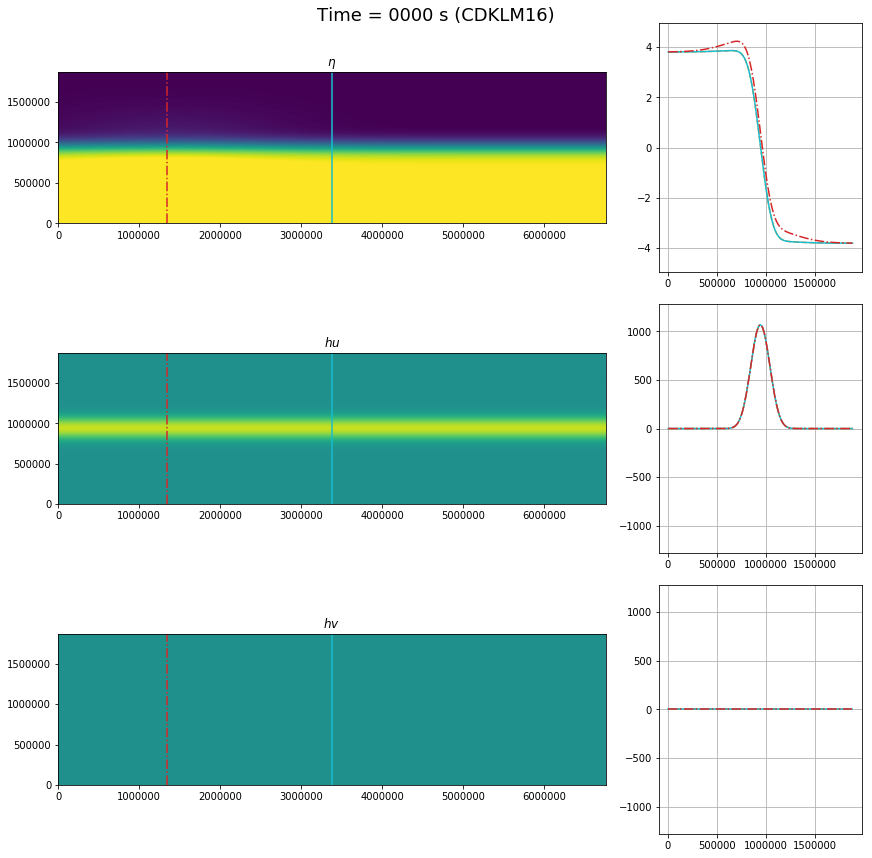

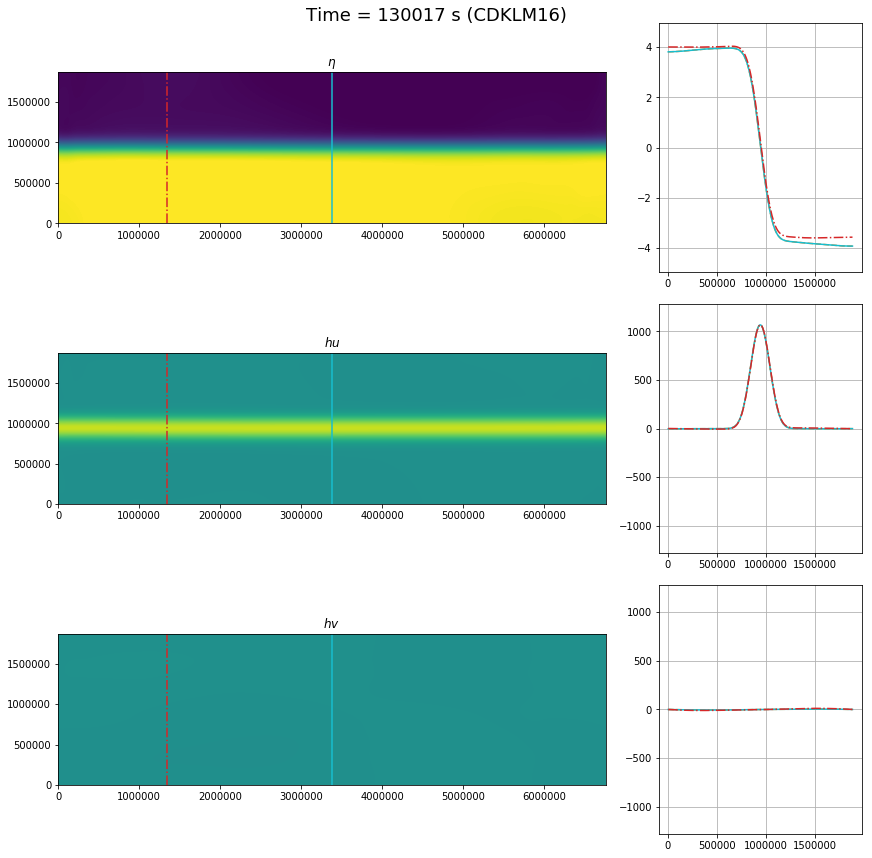

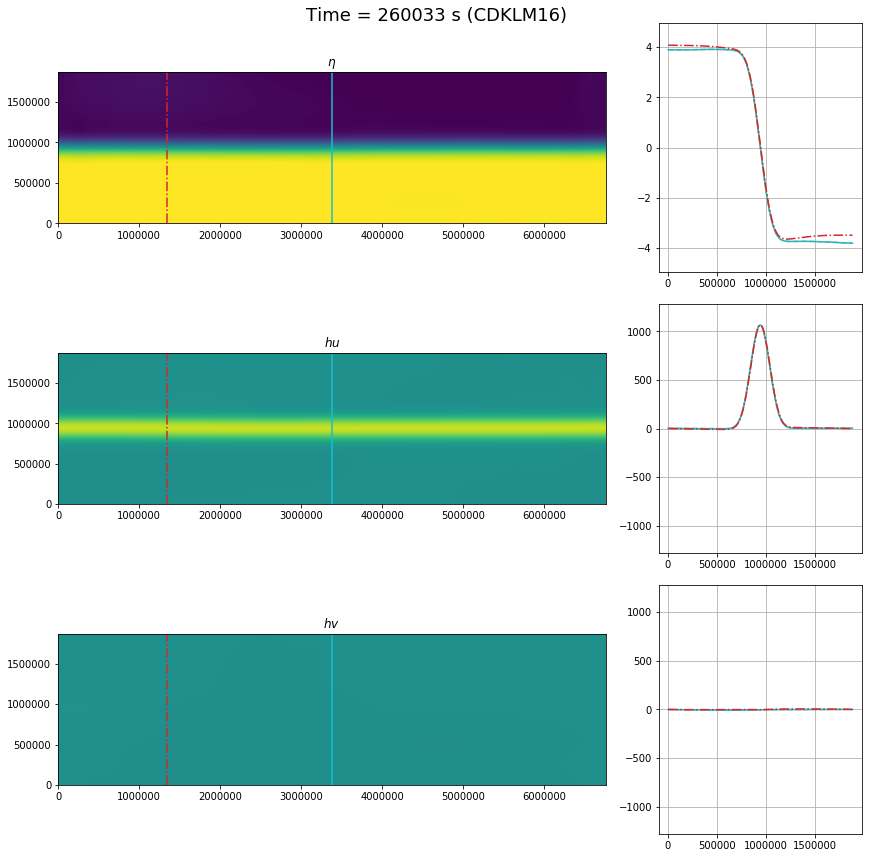

In [93]:
if 'sim' in globals():
    sim.cleanUp()
reload(CDKLM16)
    
ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    hu0[:,i] = redef_hu_init

eta_max = np.max(np.abs(eta0))*1.2
hu_max = np.max(np.abs(hu0))*1.2
print("max eta and hu: ", (eta_max, hu_max))

#Create perturbation
perturb_eta(eta0, ghosts)

#Initialize simulator
cdklm_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0, "rk_order": 2,
              "boundary_conditions": Common.BoundaryConditions(1,2,1,2)}
print("sim_args['y_zero_reference_cell']: ", sim_args['y_zero_reference_cell'])
sim = CDKLM16.CDKLM16(**cdklm_args, **sim_args)


#Run a simulation and plot it
# init
cdklm_gravity_anim = sim_animation(sim, T=80, plot_dt=50,  crossection=True)
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run and save
cdklm_gravity_anim.save(imgdir+'/gravity_double_galewsky_cdklm_1.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run and save
cdklm_gravity_anim.save(imgdir+'/gravity_double_galewsky_cdklm_2.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)


#sim_animation(sim, T=30, plot_dt=50,  crossection=True)
#sim_animation(sim, T=90, plot_dt=500, crossection=True, spinUp=True)
print("done")


# Long term instability - CDKLM

We observe the instabilities in this long running simulation.

sim_h_init.shape:  (304,)
eta0.shape (304, 504)
(ny, nx):  (300, 500)
max eta and hu:  (2.6904144, 855.39111328125)
sim_args['y_zero_reference_cell']:  0.0
sim.download in sim_animator - eta1.shape:  (300, 500)
sim.download in sim_animator - eta1.shape:  (300, 500)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (300, 500)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (300, 500

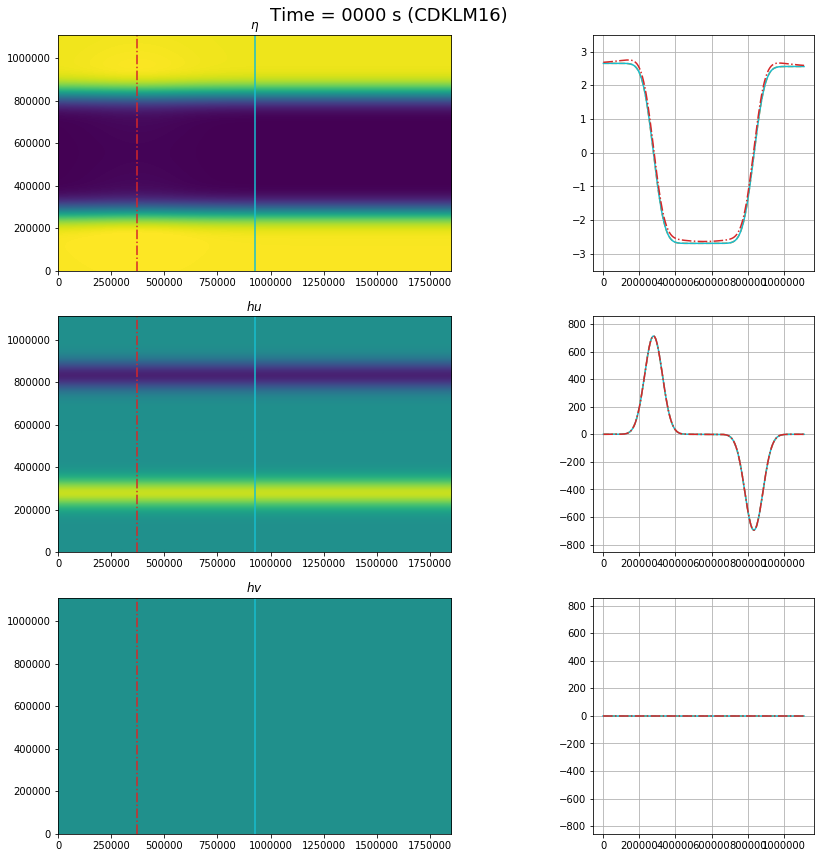

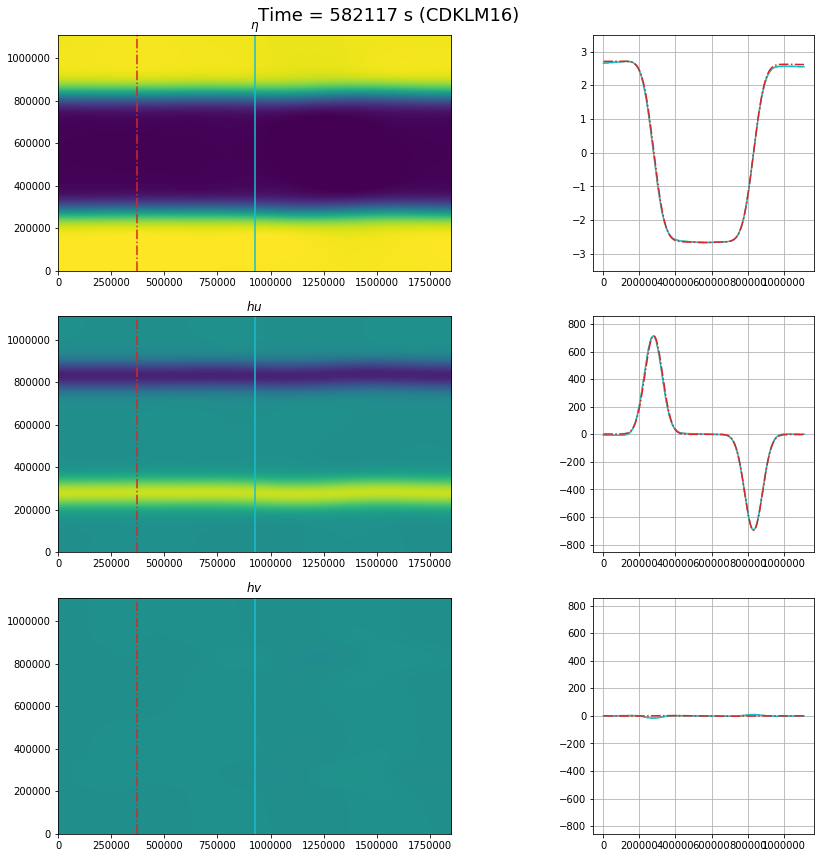

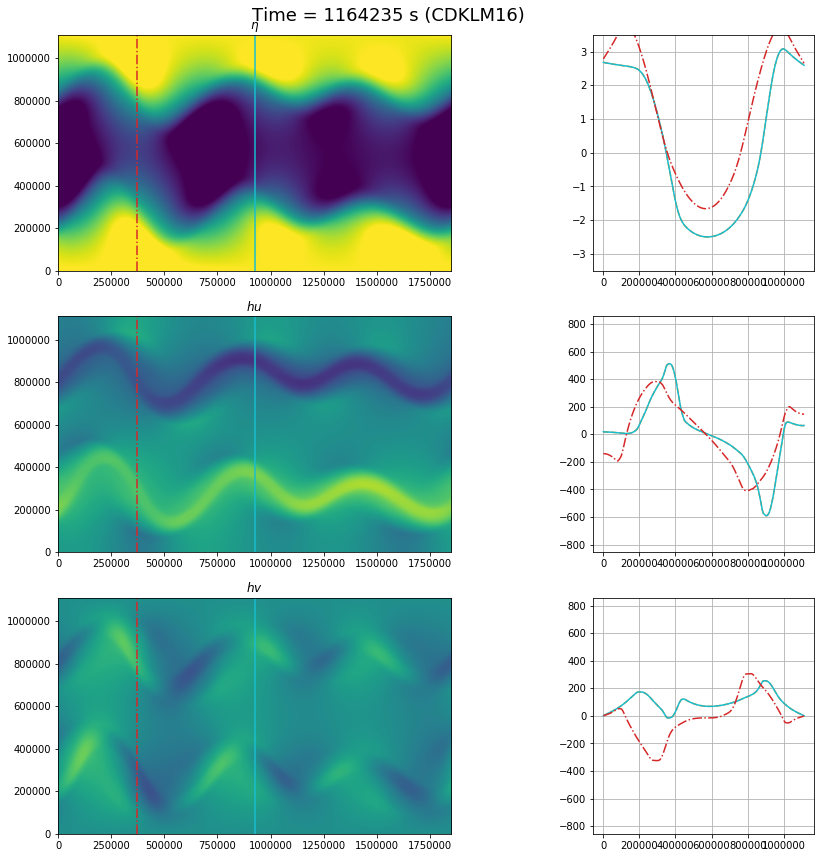

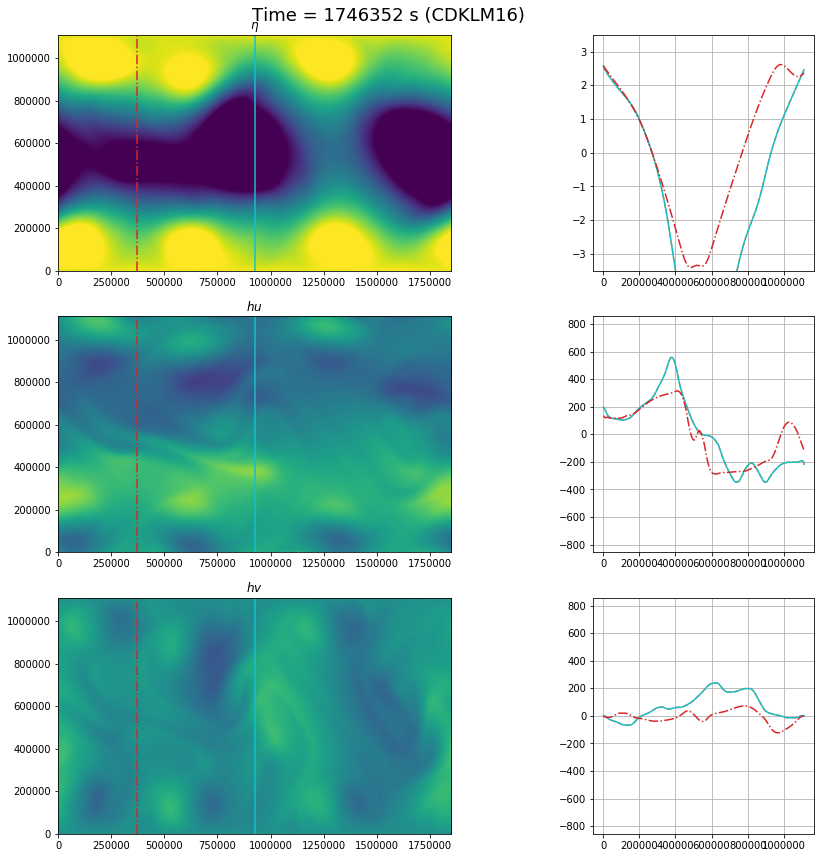

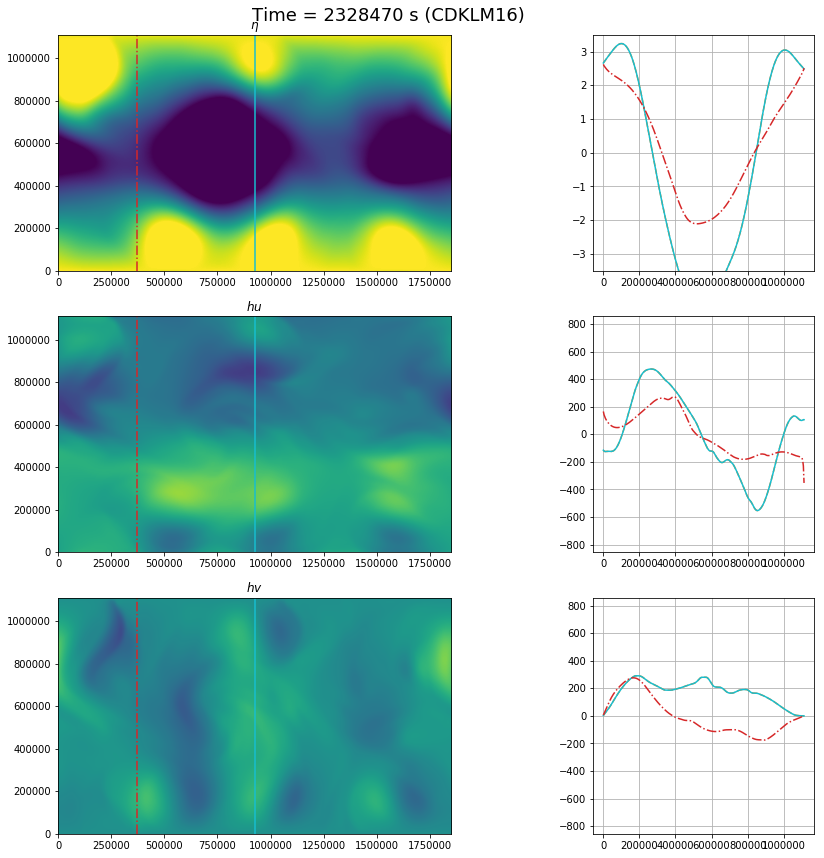

In [27]:
if 'sim' in globals():
    sim.cleanUp()
reload(CDKLM16)
    
ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    hu0[:,i] = redef_hu_init

eta_max = np.max(np.abs(eta0))
hu_max = np.max(np.abs(hu0))*1.2
print("max eta and hu: ", (eta_max, hu_max))

#Create perturbation
perturb_eta(eta0, ghosts)

#Initialize simulator
cdklm_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0, "rk_order": 2,
              "boundary_conditions": Common.BoundaryConditions(1,2,1,2)}
print("sim_args['y_zero_reference_cell']: ", sim_args['y_zero_reference_cell'])
sim = CDKLM16.CDKLM16(**cdklm_args, **sim_args)



#Run a simulation and plot it
#sim_animation(sim, T=20, plot_dt=100,  crossection=True)

# init
cdklm_galewsky_anim = sim_animation(sim, T=80, plot_dt=500, crossection=True, spinUp=False)
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save(imgdir+'/double_galewsky_cdklm_1.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save(imgdir+'/double_galewsky_cdklm_2.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save(imgdir+'/double_galewsky_cdklm_3.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save(imgdir+'/double_galewsky_cdklm_4.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
print("Done")

# Long term instabilities with drifters

sim_h_init.shape:  (304,)
eta0.shape (304, 504)
(ny, nx):  (300, 500)
max eta and hu:  (2.2635322, 847.0995849609375)
phi_delta:   0.09599310885968812
pert_alpha:  0.09599310885968812
pert_beta:   0.019198621771937624
sim_args['y_zero_reference_cell']:  0.0
sim.download in sim_animator - eta1.shape:  (300, 500)
sim.download in sim_animator - eta1.shape:  (300, 500)
sim.download in sim_animator - eta1.shape:  (300, 500)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (300, 500)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53.

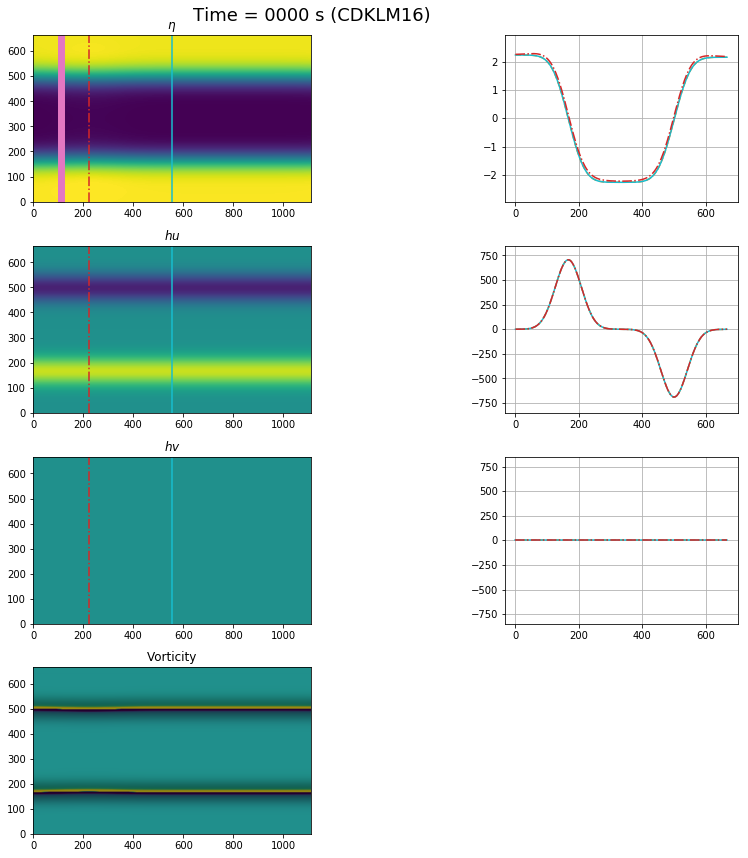

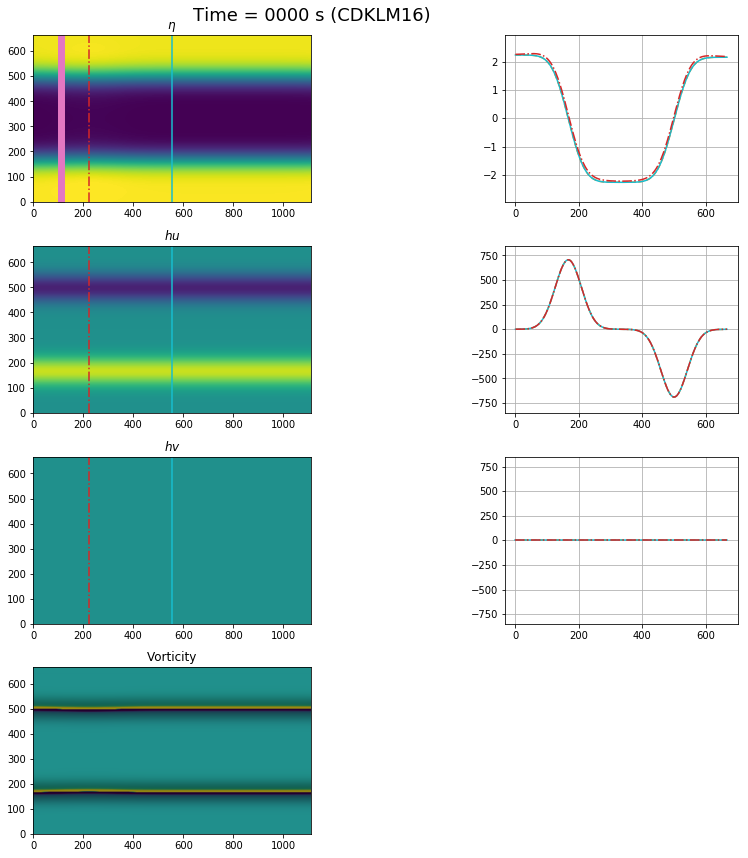

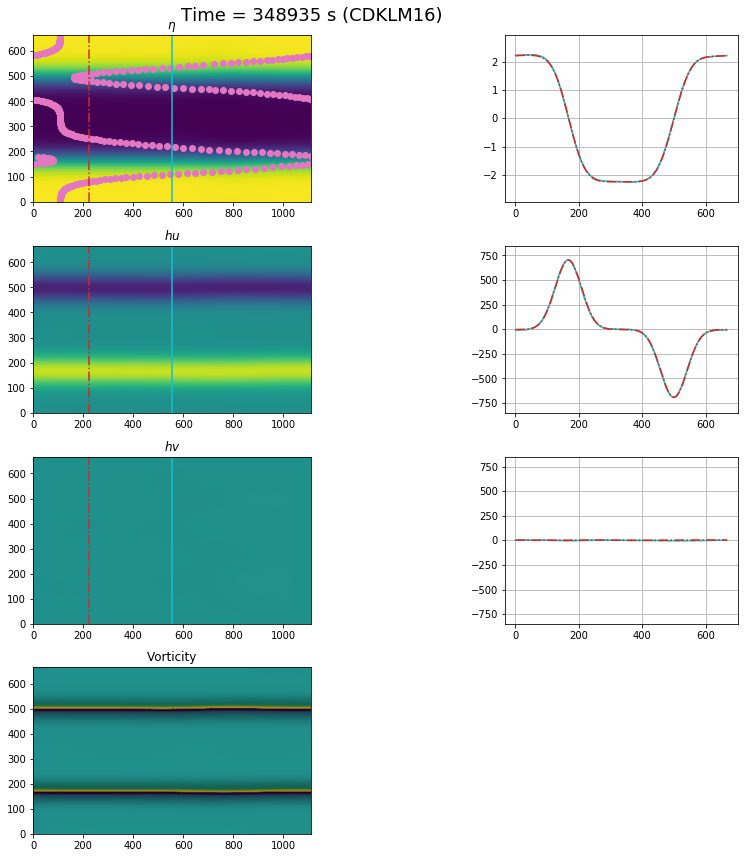

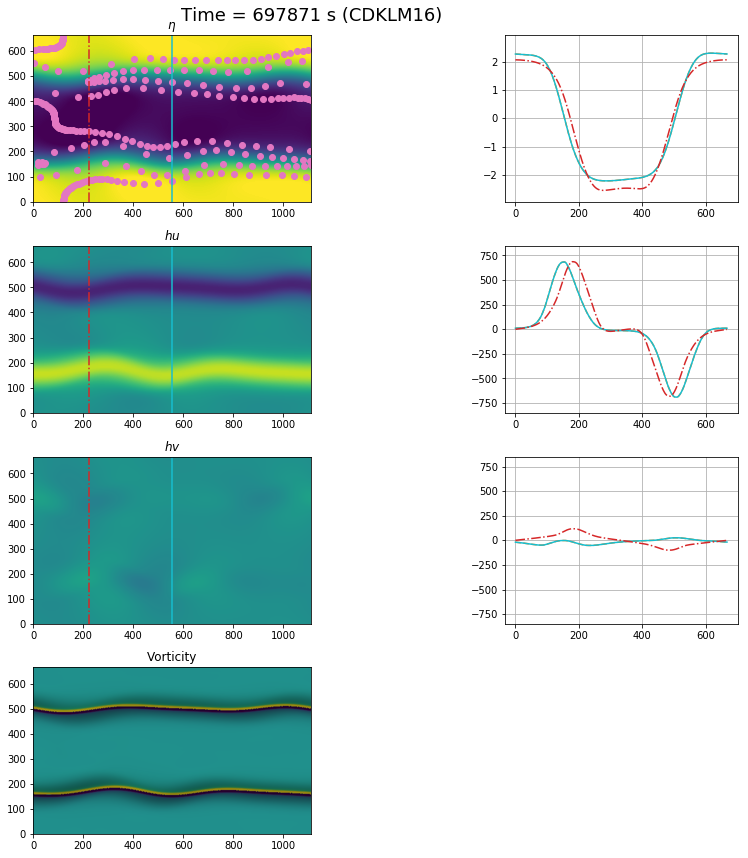

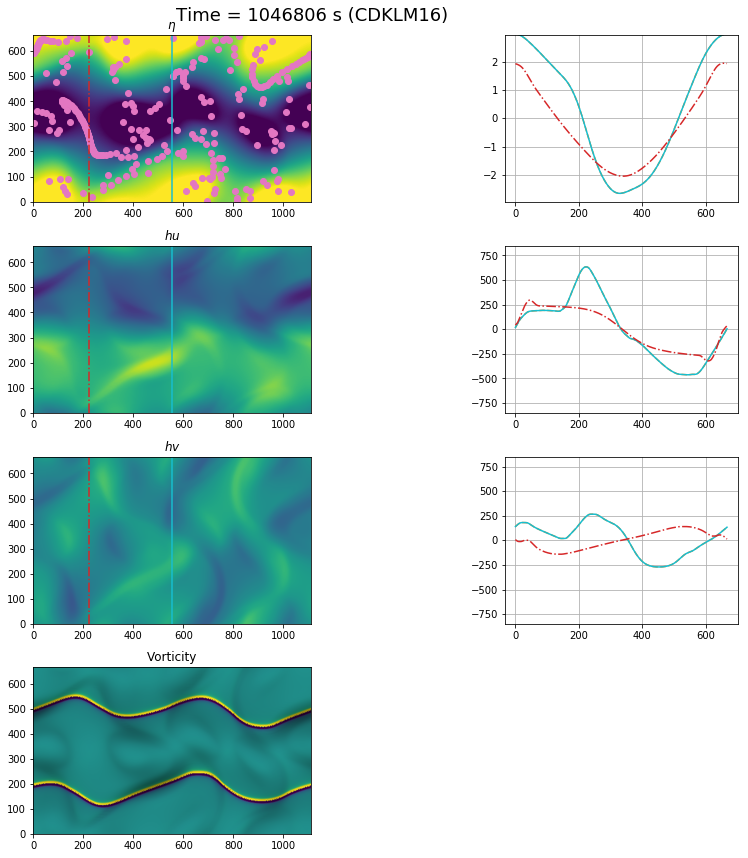

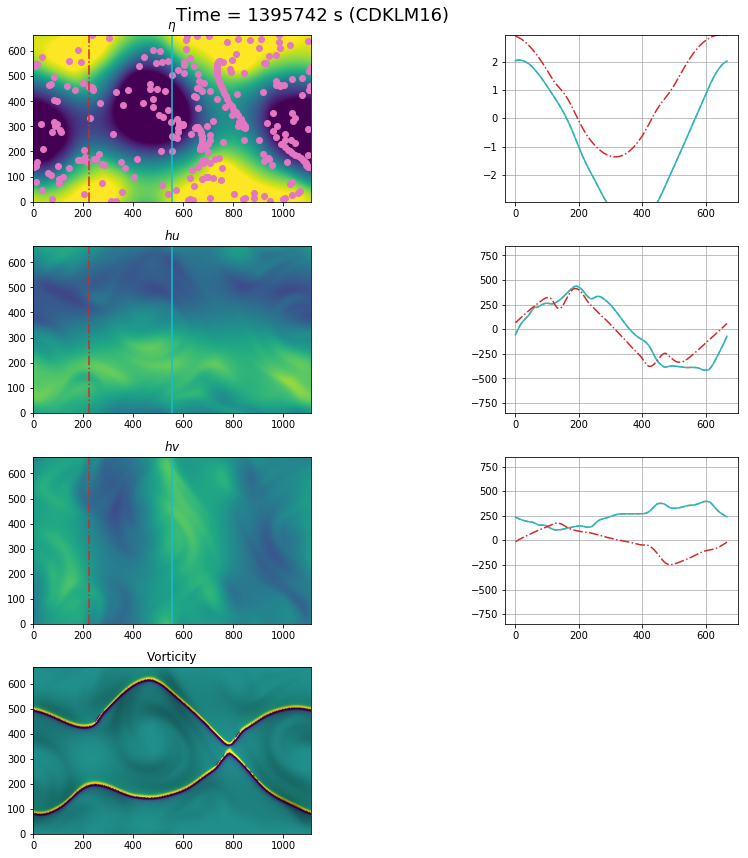

In [19]:
%%time

if 'sim' in globals():
    sim.cleanUp()
reload(CDKLM16)
    
ghosts = np.array([2,2,2,2]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    hu0[:,i] = redef_hu_init

eta_max = np.max(np.abs(eta0))
hu_max = np.max(np.abs(hu0))*1.2
print("max eta and hu: ", (eta_max, hu_max))

#Create perturbation
perturb_eta(eta0, ghosts)

#Initialize simulator
cdklm_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0, "rk_order": 2,
              "boundary_conditions": Common.BoundaryConditions(2,2,2,2)}
print("sim_args['y_zero_reference_cell']: ", sim_args['y_zero_reference_cell'])
sim = CDKLM16.CDKLM16(**cdklm_args, **sim_args)


drifters_for_sim = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, sim.ny,
                                                             boundaryConditions=cdklm_args["boundary_conditions"],
                                                             domain_size_x=sim.nx*sim.dx, 
                                                             domain_size_y=sim.ny*sim.dy)
drifter_positions = np.zeros((sim.ny, 2))
for i in range(sim.ny):
    drifter_positions[i,0] = sim.dx*50
    drifter_positions[i,1] = sim.dy*(i+0.5)
drifters_for_sim.setDrifterPositions(drifter_positions)

sim.attachDrifters(drifters_for_sim)

#-----------------------------------------------------------
#"MAKE THIS ONE DISPLAY DRIFTERS IF SIM HAS DRIFTERS"
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
#-------------------------------------------------------------


#if False:



#Run a simulation and plot it
#sim_animation(sim, T=20, plot_dt=100,  crossection=True)

# init
cdklm_galewsky_anim = sim_animation(sim, T=80, plot_dt=500, crossection=True, spinUp=False)
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save(imgdir+'/drifters_galewsky_cdklm_1.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save(imgdir+'/drifters_galewsky_cdklm_2.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save(imgdir+'/drifters_galewsky_cdklm_3.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

# run, animate and save
cdklm_galewsky_anim.save(imgdir+'/drifters_galewsky_cdklm_4.mp4')
# plot
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
print("Done")
    
    
#cdklm_galewsky_anim = sim_animation(sim, T=10, plot_dt=500, crossection=True, spinUp=False)
#cdklm_galewsky_anim

sim_h_init.shape:  (304,)
eta0.shape (304, 504)
(ny, nx):  (300, 500)
max eta and hu:  (11.022162, 954.6359619140625)
mid_cell_x_pos, mid_cell_x_neg 192 4
phi_delta:   0.21464711678179998
pert_alpha:  0.21464711678179998
pert_beta:   0.04292942335636
sim_args['y_zero_reference_cell']:  0.0
0 t: 715942.0166015625
1 t: 1431884.033203125
2 t: 2147826.0498046875
3 t: 2863768.06640625
4 t: 3579710.0830078125
5 t: 4295652.099609375
6 t: 5011594.1162109375
7 t: 5727536.1328125
8 t: 6443478.1494140625
9 t: 7159420.166015625
sim.download in sim_animator - eta1.shape:  (300, 500)
CPU times: user 1min 2s, sys: 4.67 s, total: 1min 6s
Wall time: 1min 6s


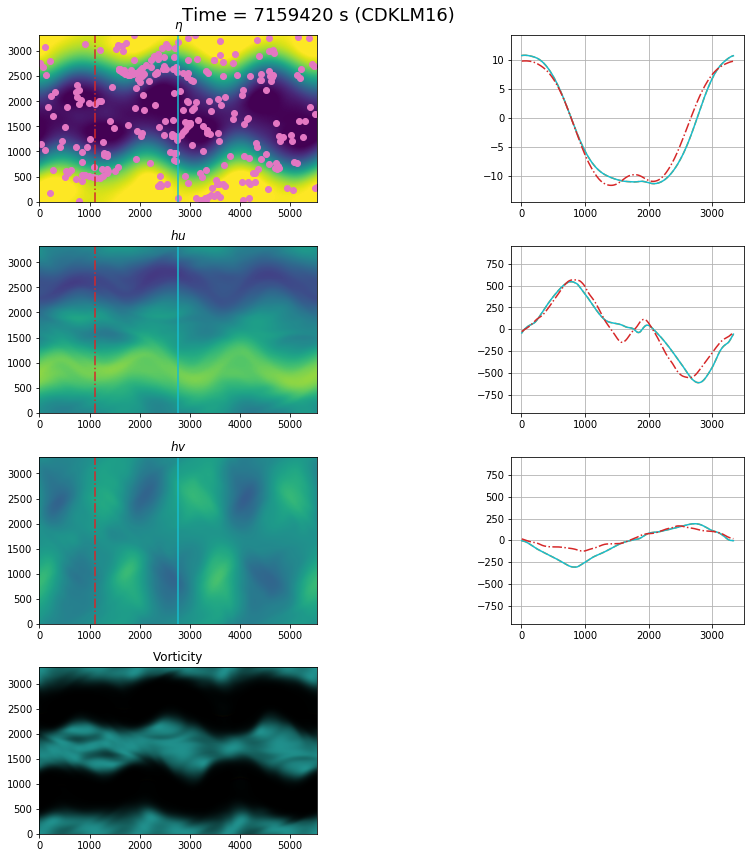

In [156]:
%%time
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    hu0[:,i] = redef_hu_init

eta_max = np.max(np.abs(eta0))
hu_max = np.max(np.abs(hu0))*1.2
print("max eta and hu: ", (eta_max, hu_max))

#Create perturbation
random_perturb_eta(eta0, ghosts)

#Initialize simulator
cdklm_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0, "rk_order": 2,
              "boundary_conditions": Common.BoundaryConditions(2,2,2,2)}
print("sim_args['y_zero_reference_cell']: ", sim_args['y_zero_reference_cell'])

sim = CDKLM16.CDKLM16(**cdklm_args, **sim_args)


drifters_for_sim = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, sim.ny,
                                                             boundaryConditions=cdklm_args["boundary_conditions"],
                                                             domain_size_x=sim.nx*sim.dx, 
                                                             domain_size_y=sim.ny*sim.dy)
drifter_positions = np.zeros((sim.ny, 2))
for i in range(sim.ny):
    drifter_positions[i,0] = sim.dx*50
    drifter_positions[i,1] = sim.dy*(i+0.5)
drifters_for_sim.setDrifterPositions(drifter_positions)

sim.attachDrifters(drifters_for_sim)

num_steps = 500*80*4

for i in range(10):
    t = sim.step((num_steps/10)*sim.dt)
    print(i, "t: " + str(t))
    
#-----------------------------------------------------------
#"MAKE THIS ONE DISPLAY DRIFTERS IF SIM HAS DRIFTERS"
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
#-------------------------------------------------------------

## Starting with a model error type perturbation

sim_h_init.shape:  (304,)
eta0.shape (304, 504)
(ny, nx):  (300, 500)
max eta and hu:  (2.2635322, 847.0995849609375)
sim_args['y_zero_reference_cell']:  0.0
0 t: 0.0
1 t: 0.0
2 t: 0.0
3 t: 0.0
4 t: 0.0
5 t: 0.0
6 t: 0.0
7 t: 0.0
8 t: 0.0
9 t: 0.0
sim.download in sim_animator - eta1.shape:  (300, 500)
sim.download in sim_animator - eta1.shape:  (300, 500)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79.sim.download in sim_animator - eta1.shape:  (300, 500)
.0..0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..

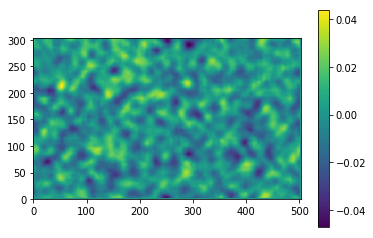

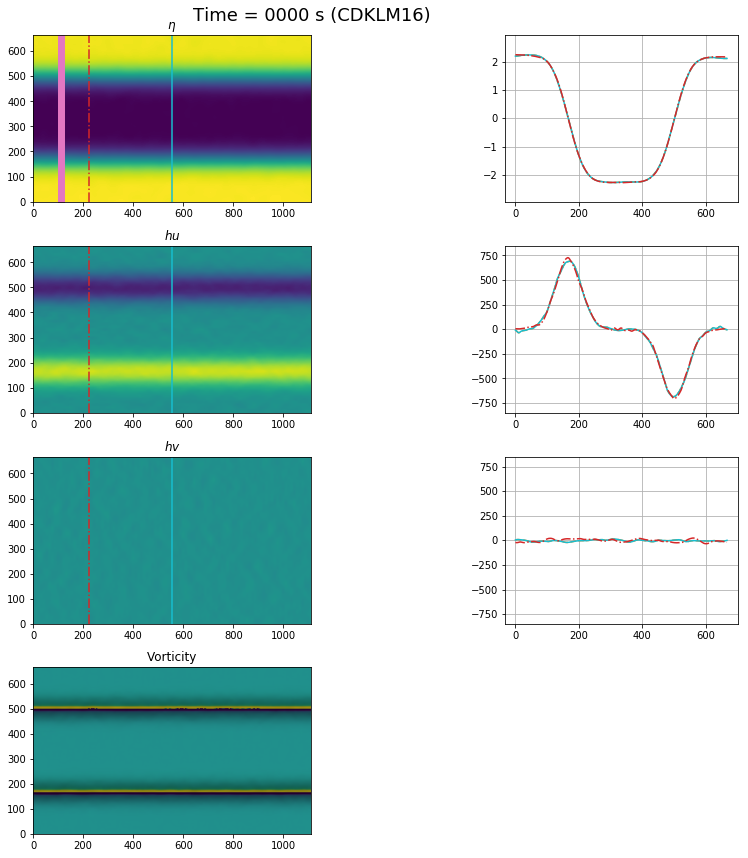

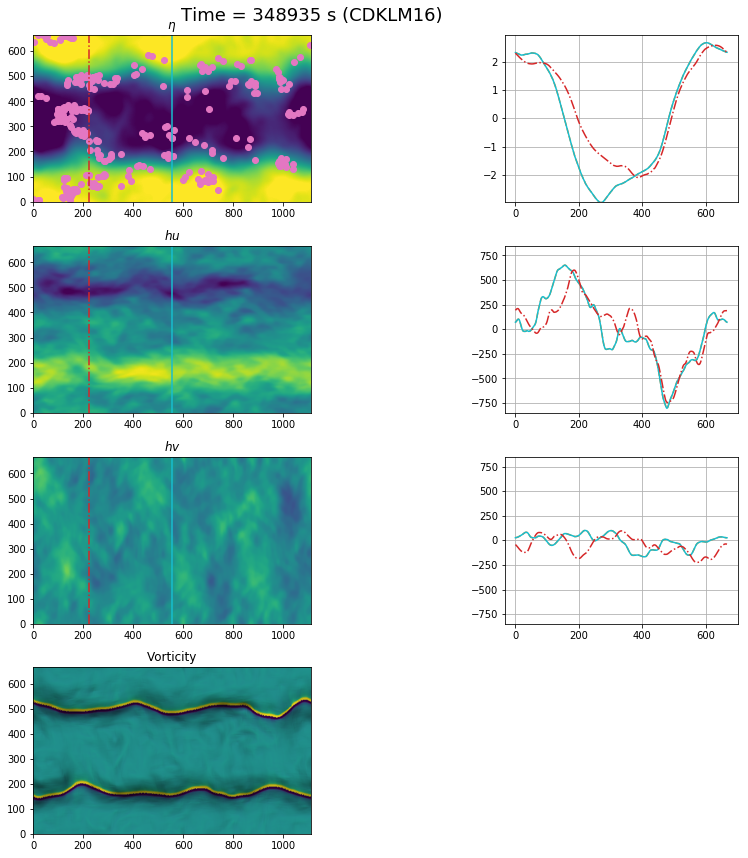

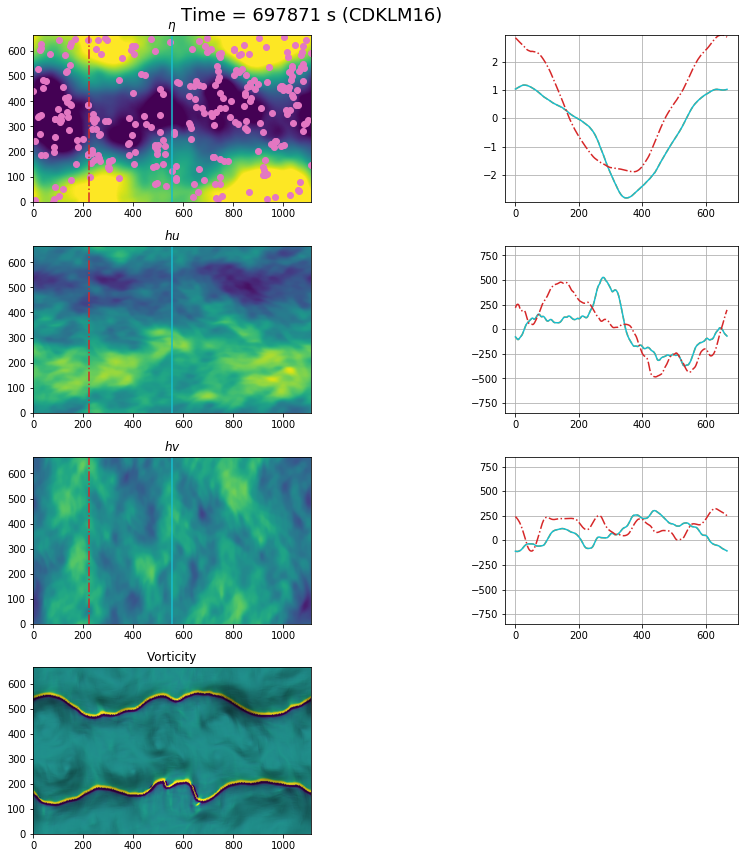

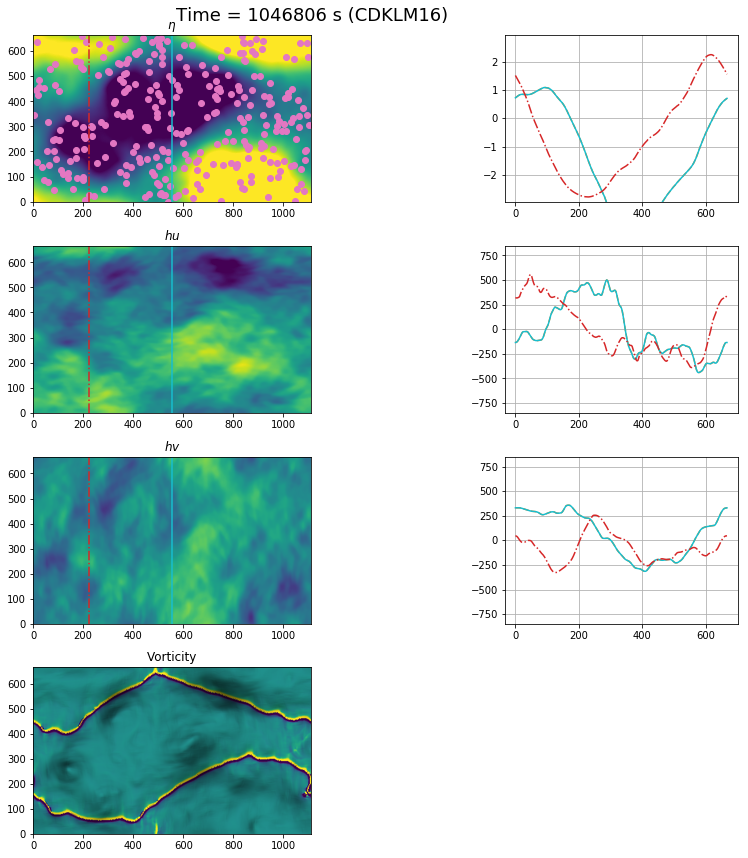

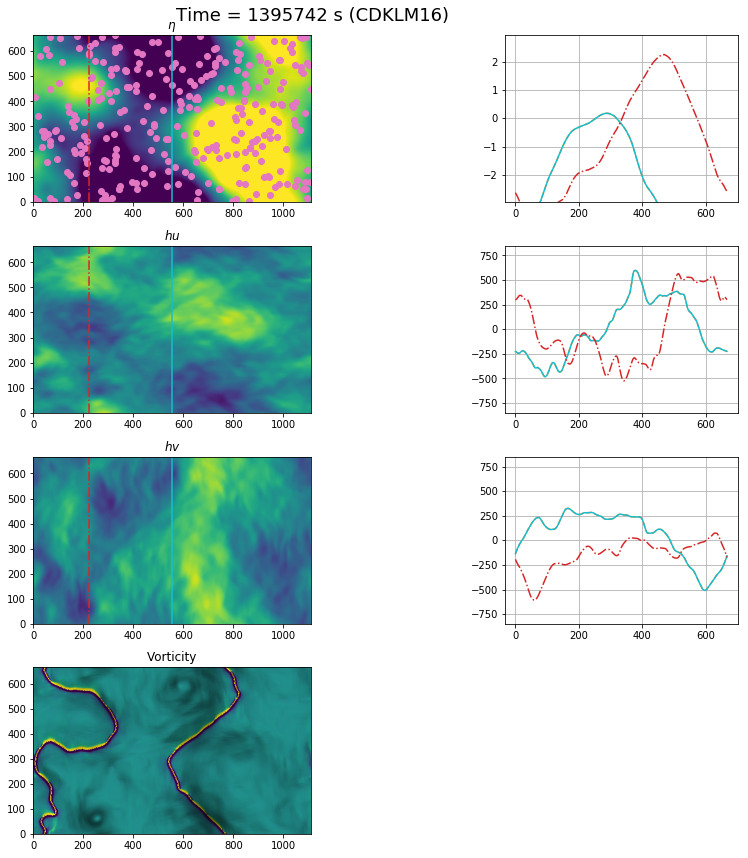

In [23]:
#%%time
H = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
hu0 = np.zeros(dataShape, dtype=np.float32)
hv0 = np.zeros(dataShape, dtype=np.float32)

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init
    hu0[:,i] = redef_hu_init
    pass
    
eta_max = np.max(np.abs(eta0))
hu_max = np.max(np.abs(hu0))*1.2
print("max eta and hu: ", (eta_max, hu_max))

#Create perturbation
#random_perturb_eta(eta0, ghosts)

#Initialize simulator
cdklm_args = {"H": H, "eta0": eta0, "hu0": hu0, "hv0": hv0, "rk_order": 2,
              "boundary_conditions": Common.BoundaryConditions(2,2,2,2),
              "small_scale_perturbation": True,
              "small_scale_perturbation_amplitude": 0.0003,
              "small_scale_perturbation_interpolation_factor": 5}
print("sim_args['y_zero_reference_cell']: ", sim_args['y_zero_reference_cell'])

sim = CDKLM16.CDKLM16(**cdklm_args, **sim_args)

sim.perturbState(q0_scale=20)
#sim.small_scale_perturbation = False
#sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

eta1, hu1, hv1 = sim.download(interior_domain_only=False)
fig = plt.figure()
plt.imshow(eta1-eta0, origin='lower')
plt.colorbar()


drifters_for_sim = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, sim.ny,
                                                             boundaryConditions=cdklm_args["boundary_conditions"],
                                                             domain_size_x=sim.nx*sim.dx, 
                                                             domain_size_y=sim.ny*sim.dy)
drifter_positions = np.zeros((sim.ny, 2))
for i in range(sim.ny):
    drifter_positions[i,0] = sim.dx*50
    drifter_positions[i,1] = sim.dy*(i+0.5)
drifters_for_sim.setDrifterPositions(drifter_positions)

sim.attachDrifters(drifters_for_sim)

num_steps = 500*80*4

t = 0.0
for i in range(10):
    #t = sim.step((num_steps/10)*sim.dt, apply_stochastic_term=False)
    print(i, "t: " + str(t))
    
#-----------------------------------------------------------
#"MAKE THIS ONE DISPLAY DRIFTERS IF SIM HAS DRIFTERS"
#sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
#anim = sim_animation(sim, T=20, plot_dt=1000, crossection=True)
#-------------------------------------------------------------

if True:
    # init
    cdklm_galewsky_anim = sim_animation(sim, T=80, plot_dt=500, crossection=True, spinUp=False)
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

    # run, animate and save
    cdklm_galewsky_anim.save(imgdir+'/drifters_modelerror_galewsky_cdklm_1.mp4')
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

    # run, animate and save
    cdklm_galewsky_anim.save(imgdir+'/drifters_modelerror_galewsky_cdklm_2.mp4')
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

    # run, animate and save
    cdklm_galewsky_anim.save(imgdir+'/drifters_modelerror_galewsky_cdklm_3.mp4')
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

    # run, animate and save
    cdklm_galewsky_anim.save(imgdir+'/drifters_modelerror_galewsky_cdklm_4.mp4')
    # plot
    sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
    print("Done")

#anim

In [31]:
sim.f

0.00013704477

In [ ]:
CRASH

# Long term instability - CTCS

Instabilitis in CTCS generates very strong eddies when they enter the Flow Relaxation zone, and these eddies dominate the solution. There are very few similarities between the CTCS results and the CDKLM results.

In [ ]:
if 'sim' in globals():
    sim.cleanUp()

ghosts = np.array([1,1,1,1]) # north, east, south, west
dataShape = (sim_args["ny"] + ghosts[0]+ghosts[2], 
             sim_args["nx"] + ghosts[1]+ghosts[3])

h0 = np.ones(dataShape, dtype=np.float32) * sim_h_init_mean
eta0 = -np.ones(dataShape, dtype=np.float32) * sim_h_init_mean;
u0 = np.zeros((dataShape[0], dataShape[1]+1), dtype=np.float32);
v0 = np.zeros((dataShape[0]+1, dataShape[1]), dtype=np.float32);  

print("sim_h_init.shape: ", sim_h_init.shape)
print("eta0.shape", eta0.shape)
print("(ny, nx): ", (sim_args["ny"], sim_args["nx"]))

for i in range(dataShape[1]):
    eta0[:,i] += sim_h_init[1:-1]
    u0[:,i] = redef_hu_init[1:-1]
    #u0[:,i] = sim_hu_init

eta_max = np.max(np.abs(eta0))
hu_max = np.max(np.abs(u0))*1.2
print("max eta and hu: ", (eta_max, hu_max))
    
#Create perturbation
perturb_eta(eta0, ghosts)
    
#Initialize simulator
ctcs_args = {"H": h0, "eta0": eta0, "hu0": u0, "hv0": v0, "A": 10000.0,
             "boundary_conditions": Common.BoundaryConditions(2,2,2,2)}
sim = CTCS.CTCS(**ctcs_args, **sim_args)

#Run a simulation and plot it
#sim_animation(sim, T=20, plot_dt=100,  crossection=True)
ctcs_galewsky_anim = sim_animation(sim, T=80, plot_dt=500, crossection=True, spinUp=False)
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

ctcs_galewsky_anim.save(imgdir+'/ocean_galewsky_ctcs_1.mp4')
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

ctcs_galewsky_anim.save(imgdir+'/ocean_galewsky_ctcs_2.mp4')
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

ctcs_galewsky_anim.save(imgdir+'/ocean_galewsky_ctcs_3.mp4')
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)

ctcs_galewsky_anim.save(imgdir+'/ocean_galewsky_ctcs_4.mp4')
sim_animation(sim, T=None, plot_dt=None, crossection=True, snapshot=True)
print("Done")